In [ ]:
import os
import shutil
import pandas as pd

# Output directories for organized images
output_train_dir = '/media/mydisk/ICDCIT/3/organized/train_images'
output_val_dir = '/media/mydisk/ICDCIT/3/organized/val_images'
output_test_dir = '/media/mydisk/ICDCIT/3/organized/test_images'


In [2]:
from tensorflow.keras import backend as K
K.clear_session()

2024-12-03 22:32:17.411703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 22:32:17.570680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733245337.641270   68315 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733245337.659065   68315 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 22:32:17.806243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
import tensorflow as tf

# List physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, list details
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
import tensorflow as tf
import os

# Constants
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = len(os.listdir(output_train_dir)) 

# Data Parsing and Augmentation
def parse_tfrecord(example):
    # Define TFRecord schema
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Parse example
    parsed = tf.io.parse_single_example(example, feature_description)
    # Decode and preprocess image
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
    label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
    return image, label

# Dataset Loader
def load_tfrecord_dataset(filenames, batch_size, shuffle=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda x: parse_tfrecord(x), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)



In [24]:
train_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_balanced/train.tfrecord'], BATCH_SIZE)
val_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_balanced/val.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation
test_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_balanced/test.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation


In [7]:
# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
train_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_balanced/train.tfrecord')
val_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_balanced/val.tfrecord')

print(f'val_samples: {val_samples}')
print(f'train_samples: {train_samples}')

2024-12-03 22:32:21.047823: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-12-03 22:32:22.768886: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


val_samples: 366
train_samples: 2930


2024-12-03 22:32:23.031082: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
from collections import Counter

def calculate_class_weights(data_dir):
    class_counts = Counter()
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        num_samples = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[label] += num_samples
    
    # Total number of samples
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {i: total_samples / (num_classes * count) for i, count in class_counts.items()}
    
    return class_weights, class_counts

# Calculate class weights from the training directory
class_weights, class_counts = calculate_class_weights(output_train_dir)
print(f'Class weights: {class_weights}')


Class weights: {0: 0.4086471408647141, 1: 1.9533333333333334, 2: 0.7252475247524752, 3: 3.8051948051948052, 4: 2.5042735042735043}


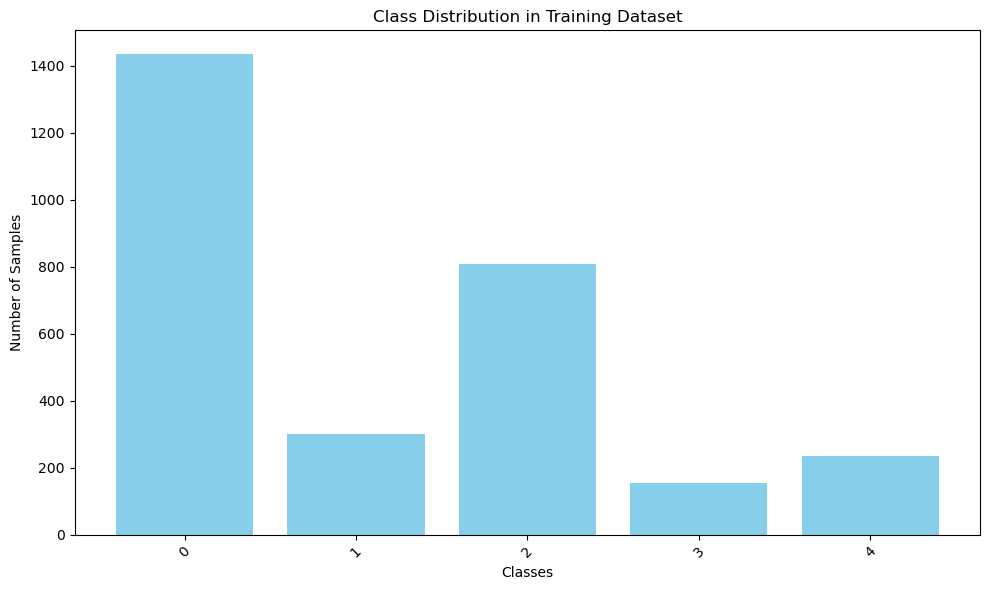

In [9]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Extract class names and counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function with your class counts dictionary
plot_class_distribution(class_counts)


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional

class SimpleMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, every_n_epochs: int = 5, save_plots: bool = False, plot_path: str = 'accuracy_loss_plot.png'):
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.save_plots = save_plots
        self.plot_path = plot_path
        self.history = {
            'epochs': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        """Store accuracy and loss at the end of each epoch."""
        if logs is None:
            logs = {}
            
        # Append accuracy and loss to history
        self.history['epochs'].append(epoch + 1)
        self.history['train_accuracy'].append(logs.get('accuracy', 0))
        self.history['val_accuracy'].append(logs.get('val_accuracy', 0))
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        
        # Log the results for this epoch
        tf.print(f'Epoch {epoch + 1}: Train Accuracy: {logs.get("accuracy", 0):.4f}, Val Accuracy: {logs.get("val_accuracy", 0):.4f}, '
                 f'Train Loss: {logs.get("loss", 0):.4f}, Val Loss: {logs.get("val_loss", 0):.4f}')
        
        # Plot the metrics every n epochs or at the last epoch
        if (epoch + 1) % self.every_n_epochs == 0 or epoch == self.params['epochs'] - 1:
            self.plot_metrics()

    def plot_metrics(self) -> None:
        """Plot accuracy and loss over epochs."""
        try:
            # Create a new figure for each plot to avoid overlapping
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Plot accuracy
            axes[0].plot(self.history['epochs'], self.history['train_accuracy'], label='Train Accuracy', marker='o')
            axes[0].plot(self.history['epochs'], self.history['val_accuracy'], label='Val Accuracy', marker='o')
            axes[0].set_title('Accuracy over Epochs')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Plot loss
            axes[1].plot(self.history['epochs'], self.history['train_loss'], label='Train Loss', marker='o')
            axes[1].plot(self.history['epochs'], self.history['val_loss'], label='Val Loss', marker='o')
            axes[1].set_title('Loss over Epochs')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            
            # Save or show the plot
            if self.save_plots:
                plt.savefig(self.plot_path)
                plt.close()  # Close the figure to avoid display in interactive environments
            else:
                plt.show()  # Show the plot in interactive mode
                
        except Exception as e:
            tf.print(f"Error plotting metrics: {str(e)}")


In [14]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, 
                                     Dropout, BatchNormalization, Conv2D, 
                                     multiply, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal


base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
optimizer=Adam(learning_rate=0.0001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=True)

history = model.fit(
train_dataset,
steps_per_epoch=train_samples // BATCH_SIZE,
validation_data=val_dataset,
validation_steps=val_samples // BATCH_SIZE,
epochs=25,               
callbacks=[custom_metrics_callback, model_checkpoint],
class_weight=class_weights
)


Epoch 1/25


2024-12-03 22:37:07.413965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6706 - auc: 0.8657 - loss: 0.9603 - precision_1: 0.7602 - recall_1: 0.5278

2024-12-03 22:37:42.832178: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1387', 4 bytes spill stores, 4 bytes spill loads



Epoch 1: Train Accuracy: 0.5802, Val Accuracy: 0.5344, Train Loss: 1.5562, Val Loss: 1.0701

Epoch 1: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 64s 240ms/step - accuracy: 0.6686 - auc: 0.8650 - loss: 0.9732 - precision_1: 0.7590 - recall_1: 0.5258 - val_accuracy: 0.5344 - val_auc: 0.8549 - val_loss: 1.0701 - val_precision_1: 0.6376 - val_recall_1: 0.4563
Epoch 2/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 23:04 31s/step - accuracy: 0.4000 - auc: 0.7740 - loss: 1.7271 - precision_1: 0.8750 - recall_1: 0.1400Epoch 2: Train Accuracy: 0.4000, Val Accuracy: 0.5375, Train Loss: 1.7271, Val Loss: 1.0642

Epoch 2: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.4000 - auc: 0.7740 - loss: 1.7271 - precision_1: 0.8750 - recall_1: 0.1400 - val_accuracy: 0.5375 - val_auc: 0.8558 - val_loss: 1.0642 - val_precision_1: 0.6637 - val_recall_1: 0.4625
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3352 - auc: 0.5679 - loss: 1.0368 - precision_1: 0.745

2024-12-03 22:38:40.915436: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 6: Train Accuracy: 0.7200, Val Accuracy: 0.5031, Train Loss: 0.9632, Val Loss: 1.3272

Epoch 6: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7200 - auc: 0.9497 - loss: 0.9632 - precision_1: 0.8438 - recall_1: 0.5400 - val_accuracy: 0.5031 - val_auc: 0.8509 - val_loss: 1.3272 - val_precision_1: 0.5392 - val_recall_1: 0.4938
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6570 - auc: 0.8890 - loss: 0.5432 - precision_1: 0.8222 - recall_1: 0.5056Epoch 7: Train Accuracy: 0.7462, Val Accuracy: 0.5063, Train Loss: 0.6162, Val Loss: 1.4494

Epoch 7: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6589 - auc: 0.8902 - loss: 0.5448 - precision_1: 0.8232 - recall_1: 0.5079 - val_accuracy: 0.5063 - val_auc: 0.8604 - val_loss: 1.4494 - val_precision_1: 0.5314 - val_recall_1: 0.5031
Epoch 8/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7000 - auc: 0.9537 - loss: 0.6396 - precision_1: 0.8000 - r

2024-12-03 22:38:48.966629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7941 - auc: 0.9570 - loss: 0.3572 - precision_1: 0.8995 - recall_1: 0.6932Epoch 9: Train Accuracy: 0.8469, Val Accuracy: 0.5031, Train Loss: 0.4047, Val Loss: 1.5513

Epoch 9: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7952 - auc: 0.9574 - loss: 0.3583 - precision_1: 0.9000 - recall_1: 0.6948 - val_accuracy: 0.5031 - val_auc: 0.8438 - val_loss: 1.5513 - val_precision_1: 0.5227 - val_recall_1: 0.5031
Epoch 10/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8400 - auc: 0.9805 - loss: 0.6180 - precision_1: 0.8913 - recall_1: 0.8200Epoch 10: Train Accuracy: 0.8400, Val Accuracy: 0.4969, Train Loss: 0.6180, Val Loss: 1.5322

Epoch 10: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8400 - auc: 0.9806 - loss: 0.6180 - precision_1: 0.8913 - recall_1: 0.8200 - val_accuracy: 0.4969 - val_auc: 0.8445 - val_loss: 1.5322 - val_precision_1: 0.5196 - val_recall_1:

2024-12-03 22:39:09.316594: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9595 - auc: 0.9937 - loss: 0.1200 - precision_1: 0.9672 - recall_1: 0.9400Epoch 15: Train Accuracy: 0.9660, Val Accuracy: 0.5500, Train Loss: 0.1385, Val Loss: 1.6349

Epoch 15: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9596 - auc: 0.9938 - loss: 0.1204 - precision_1: 0.9673 - recall_1: 0.9403 - val_accuracy: 0.5500 - val_auc: 0.8303 - val_loss: 1.6349 - val_precision_1: 0.5772 - val_recall_1: 0.5375
Epoch 16/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9800 - auc: 0.9988 - loss: 0.1019 - precision_1: 0.9800 - recall_1: 0.9800Epoch 16: Train Accuracy: 0.9800, Val Accuracy: 0.5500, Train Loss: 0.1019, Val Loss: 1.6283

Epoch 16: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9800 - auc: 0.9988 - loss: 0.1019 - precision_1: 0.9800 - recall_1: 0.9800 - val_accuracy: 0.5500 - val_auc: 0.8327 - val_loss: 1.6283 - val_precision_1: 0.5831 - val_recall

2024-12-03 22:39:44.244545: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9922 - auc: 0.9997 - loss: 0.0331 - precision_1: 0.9922 - recall_1: 0.9910Epoch 25: Train Accuracy: 0.9875, Val Accuracy: 0.5688, Train Loss: 0.0534, Val Loss: 1.4011

Epoch 25: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9921 - auc: 0.9997 - loss: 0.0335 - precision_1: 0.9921 - recall_1: 0.9909 - val_accuracy: 0.5688 - val_auc: 0.8625 - val_loss: 1.4011 - val_precision_1: 0.6007 - val_recall_1: 0.5594


In [16]:
for layer in model.layers[-10:]:
    layer.trainable = True


Resuming training with a learning rate of 1e-05
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9975 - auc: 0.9997 - loss: 0.0239 - precision_2: 0.9976 - recall_2: 0.9975Epoch 1: Train Accuracy: 0.9931, Val Accuracy: 0.5906, Train Loss: 0.0327, Val Loss: 1.3158

Epoch 1: val_loss improved from inf to 1.31580, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.9974 - auc: 0.9996 - loss: 0.0241 - precision_2: 0.9975 - recall_2: 0.9974 - val_accuracy: 0.5906 - val_auc: 0.8754 - val_loss: 1.3158 - val_precision_2: 0.6190 - val_recall_2: 0.5688
Epoch 2/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 13:10 18s/step - accuracy: 0.9400 - auc: 0.9981 - loss: 0.1385 - precision_2: 0.9592 - recall_2: 0.9400Epoch 2: Train Accuracy: 0.9400, Val Accuracy: 0.5906, Train Loss: 0.1385, Val Loss: 1.3149

Epoch 2: val_loss improved from 1.31580 to 1.31491, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9400 - auc: 0.9981 - loss

2024-12-03 22:41:36.426067: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 3: Train Accuracy: 0.9927, Val Accuracy: 0.5844, Train Loss: 0.0261, Val Loss: 1.3779

Epoch 3: val_loss did not improve from 1.31491
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0179 - precision_2: 0.9967 - recall_2: 0.9965 - val_accuracy: 0.5844 - val_auc: 0.8667 - val_loss: 1.3779 - val_precision_2: 0.6100 - val_recall_2: 0.5719
Epoch 4/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0125 - precision_2: 1.0000 - recall_2: 1.0000

2024-12-03 22:41:36.812316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 4: Train Accuracy: 1.0000, Val Accuracy: 0.5844, Train Loss: 0.0125, Val Loss: 1.3779

Epoch 4: val_loss did not improve from 1.31491
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0125 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.5844 - val_auc: 0.8656 - val_loss: 1.3779 - val_precision_2: 0.6100 - val_recall_2: 0.5719
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9963 - auc: 0.9998 - loss: 0.0194 - precision_2: 0.9965 - recall_2: 0.9954

2024-12-03 22:41:41.806055: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 5: Train Accuracy: 0.9924, Val Accuracy: 0.6031, Train Loss: 0.0264, Val Loss: 1.2946


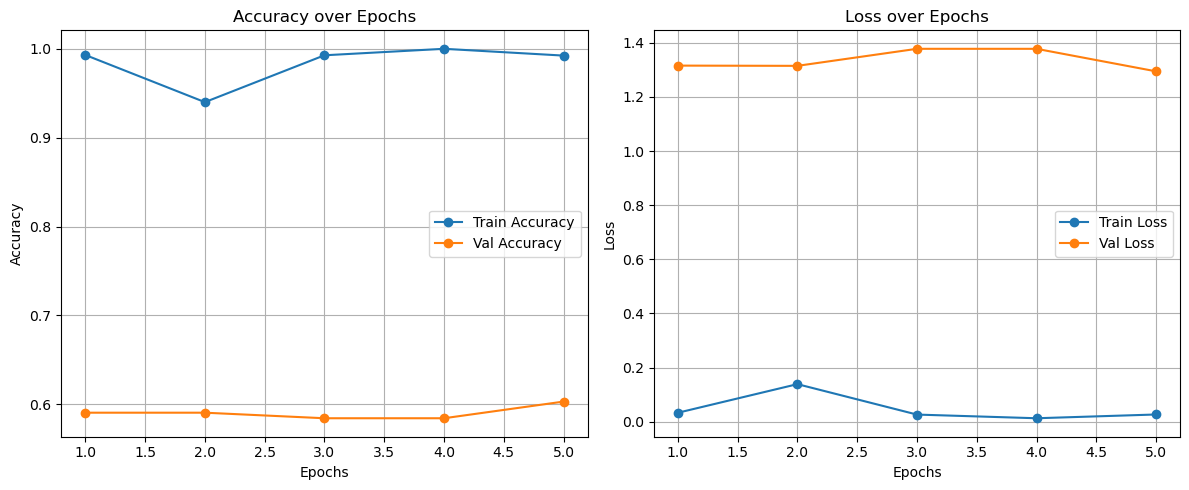


Epoch 5: val_loss improved from 1.31491 to 1.29457, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9962 - auc: 0.9998 - loss: 0.0195 - precision_2: 0.9964 - recall_2: 0.9953 - val_accuracy: 0.6031 - val_auc: 0.8772 - val_loss: 1.2946 - val_precision_2: 0.6259 - val_recall_2: 0.5750
Epoch 6/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0311 - precision_2: 1.0000 - recall_2: 1.0000Epoch 6: Train Accuracy: 1.0000, Val Accuracy: 0.6031, Train Loss: 0.0311, Val Loss: 1.2918

Epoch 6: val_loss improved from 1.29457 to 1.29178, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0311 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6031 - val_auc: 0.8774 - val_loss: 1.2918 - val_precision_2: 0.6237 - val_recall_2: 0.5750
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9963 - auc: 1.0000 - loss: 0.0176 - precision_2: 0.9966

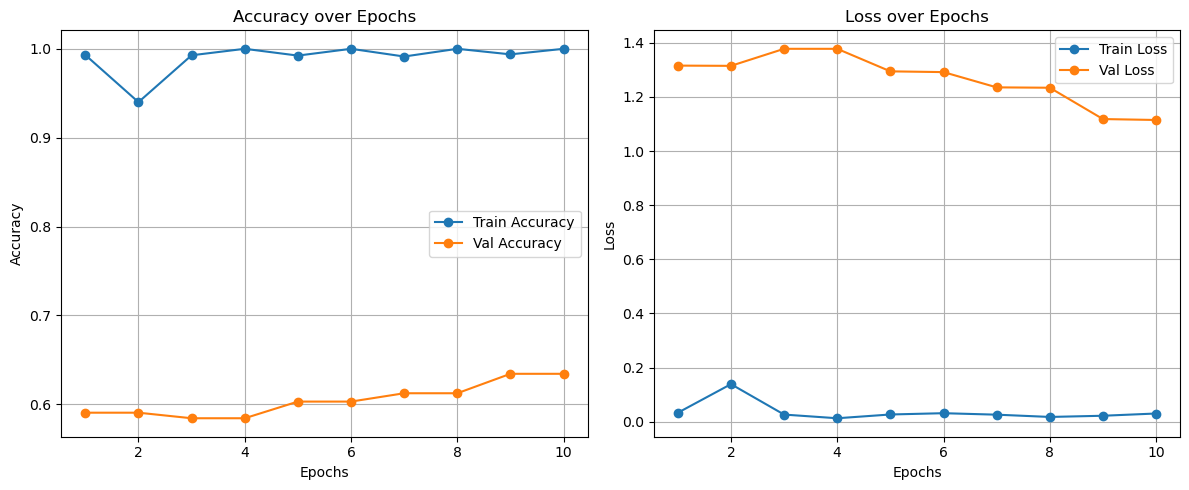


Epoch 10: val_loss improved from 1.11826 to 1.11485, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0300 - precision_2: 1.0000 - recall_2: 0.9800 - val_accuracy: 0.6344 - val_auc: 0.8986 - val_loss: 1.1148 - val_precision_2: 0.6667 - val_recall_2: 0.6062
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0125 - precision_2: 0.9976 - recall_2: 0.9973

2024-12-03 22:42:01.170780: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 11: Train Accuracy: 0.9934, Val Accuracy: 0.6531, Train Loss: 0.0185, Val Loss: 1.0046

Epoch 11: val_loss improved from 1.11485 to 1.00455, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0126 - precision_2: 0.9975 - recall_2: 0.9972 - val_accuracy: 0.6531 - val_auc: 0.9085 - val_loss: 1.0046 - val_precision_2: 0.7018 - val_recall_2: 0.6250
Epoch 12/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0394 - precision_2: 0.9800 - recall_2: 0.9800Epoch 12: Train Accuracy: 0.9800, Val Accuracy: 0.6562, Train Loss: 0.0394, Val Loss: 1.0023

Epoch 12: val_loss improved from 1.00455 to 1.00230, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0394 - precision_2: 0.9800 - recall_2: 0.9800 - val_accuracy: 0.6562 - val_auc: 0.9085 - val_loss: 1.0023 - val_precision_2: 0.6969 - val_recall_2: 0.6250
Epoch 13/50
45/45 ━━━━━

2024-12-03 22:42:08.364764: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 14: Train Accuracy: 0.9800, Val Accuracy: 0.6625, Train Loss: 0.0309, Val Loss: 0.9121

Epoch 14: val_loss improved from 0.91510 to 0.91214, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0309 - precision_2: 1.0000 - recall_2: 0.9800 - val_accuracy: 0.6625 - val_auc: 0.9209 - val_loss: 0.9121 - val_precision_2: 0.7133 - val_recall_2: 0.6375
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9971 - auc: 0.9998 - loss: 0.0143 - precision_2: 0.9973 - recall_2: 0.9967Epoch 15: Train Accuracy: 0.9931, Val Accuracy: 0.6969, Train Loss: 0.0216, Val Loss: 0.8471


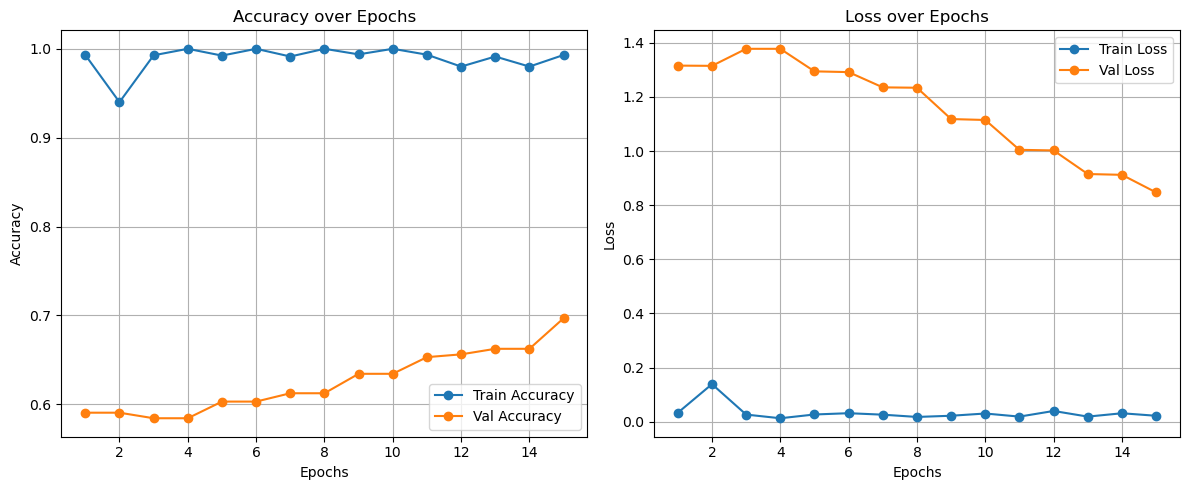


Epoch 15: val_loss improved from 0.91214 to 0.84715, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9970 - auc: 0.9998 - loss: 0.0144 - precision_2: 0.9972 - recall_2: 0.9966 - val_accuracy: 0.6969 - val_auc: 0.9296 - val_loss: 0.8471 - val_precision_2: 0.7226 - val_recall_2: 0.6594
Epoch 16/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0218 - precision_2: 1.0000 - recall_2: 1.0000

2024-12-03 22:42:15.182851: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 16: Train Accuracy: 1.0000, Val Accuracy: 0.6969, Train Loss: 0.0218, Val Loss: 0.8420

Epoch 16: val_loss improved from 0.84715 to 0.84196, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0218 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.6969 - val_auc: 0.9300 - val_loss: 0.8420 - val_precision_2: 0.7276 - val_recall_2: 0.6594
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9970 - auc: 1.0000 - loss: 0.0113 - precision_2: 0.9972 - recall_2: 0.9968Epoch 17: Train Accuracy: 0.9927, Val Accuracy: 0.7125, Train Loss: 0.0191, Val Loss: 0.7717

Epoch 17: val_loss improved from 0.84196 to 0.77168, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9970 - auc: 1.0000 - loss: 0.0114 - precision_2: 0.9971 - recall_2: 0.9967 - val_accuracy: 0.7125 - val_auc: 0.9378 - val_loss: 0.7717 - val_precision_2: 0.7604 - val_recall_2: 0.6844
Epoch 18/50
 1/45 ━━━━━

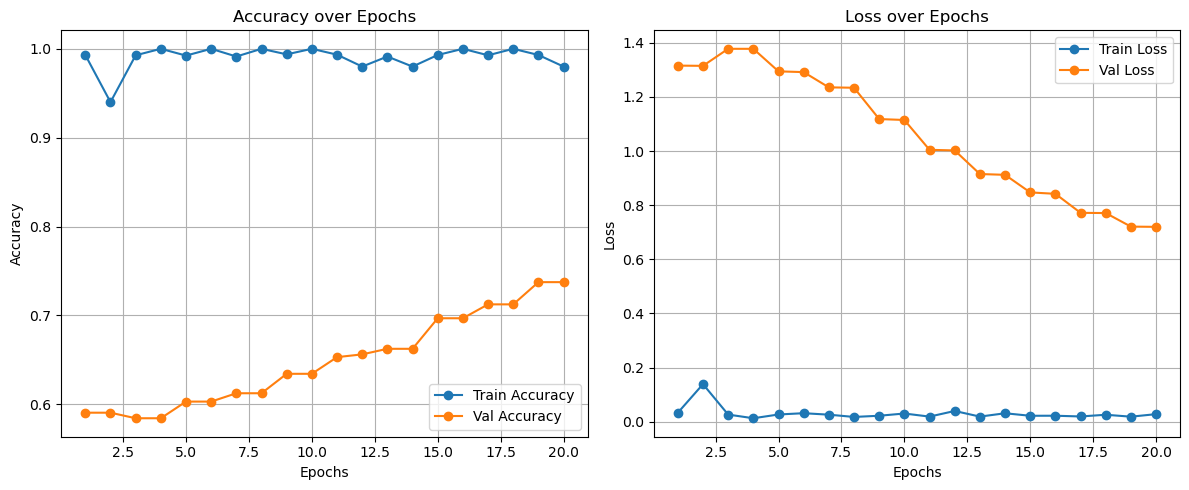


Epoch 20: val_loss improved from 0.72073 to 0.71987, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0277 - precision_2: 0.9800 - recall_2: 0.9800 - val_accuracy: 0.7375 - val_auc: 0.9449 - val_loss: 0.7199 - val_precision_2: 0.7721 - val_recall_2: 0.7094
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0096 - precision_2: 0.9978 - recall_2: 0.9970Epoch 21: Train Accuracy: 0.9924, Val Accuracy: 0.7625, Train Loss: 0.0179, Val Loss: 0.6728

Epoch 21: val_loss improved from 0.71987 to 0.67280, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0098 - precision_2: 0.9977 - recall_2: 0.9969 - val_accuracy: 0.7625 - val_auc: 0.9502 - val_loss: 0.6728 - val_precision_2: 0.7879 - val_recall_2: 0.7312
Epoch 22/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0280 - precision_2: 0

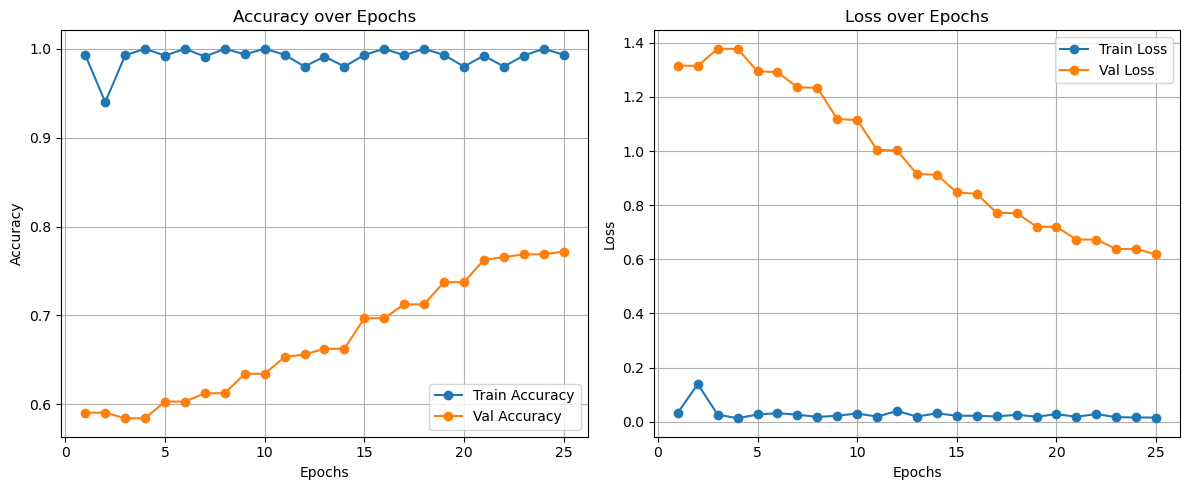


Epoch 25: val_loss improved from 0.63797 to 0.61793, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9969 - auc: 1.0000 - loss: 0.0094 - precision_2: 0.9969 - recall_2: 0.9968 - val_accuracy: 0.7719 - val_auc: 0.9565 - val_loss: 0.6179 - val_precision_2: 0.7993 - val_recall_2: 0.7469
Epoch 26/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0220 - precision_2: 0.9800 - recall_2: 0.9800Epoch 26: Train Accuracy: 0.9800, Val Accuracy: 0.7750, Train Loss: 0.0220, Val Loss: 0.6172

Epoch 26: val_loss improved from 0.61793 to 0.61718, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0220 - precision_2: 0.9800 - recall_2: 0.9800 - val_accuracy: 0.7750 - val_auc: 0.9564 - val_loss: 0.6172 - val_precision_2: 0.7993 - val_recall_2: 0.7469
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9966 - auc: 1.0000 - loss: 0.0099 - precision_2: 0

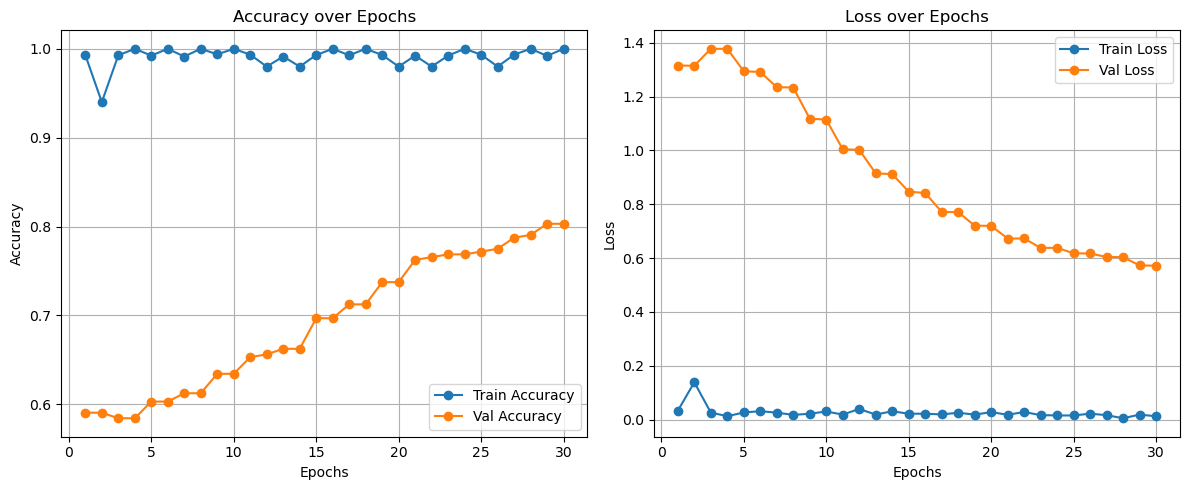


Epoch 30: val_loss improved from 0.57265 to 0.57198, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0123 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8031 - val_auc: 0.9615 - val_loss: 0.5720 - val_precision_2: 0.8212 - val_recall_2: 0.7750
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9963 - auc: 1.0000 - loss: 0.0077 - precision_2: 0.9969 - recall_2: 0.9963

2024-12-03 22:43:05.874058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 31: Train Accuracy: 0.9906, Val Accuracy: 0.8062, Train Loss: 0.0163, Val Loss: 0.5551

Epoch 31: val_loss improved from 0.57198 to 0.55511, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9962 - auc: 1.0000 - loss: 0.0079 - precision_2: 0.9968 - recall_2: 0.9961 - val_accuracy: 0.8062 - val_auc: 0.9643 - val_loss: 0.5551 - val_precision_2: 0.8257 - val_recall_2: 0.7844
Epoch 32/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0027 - precision_2: 1.0000 - recall_2: 1.0000Epoch 32: Train Accuracy: 1.0000, Val Accuracy: 0.8062, Train Loss: 0.0027, Val Loss: 0.5538

Epoch 32: val_loss improved from 0.55511 to 0.55379, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0027 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8062 - val_auc: 0.9643 - val_loss: 0.5538 - val_precision_2: 0.8317 - val_recall_2: 0.7875
Epoch 33/50
45/45 ━━━━━

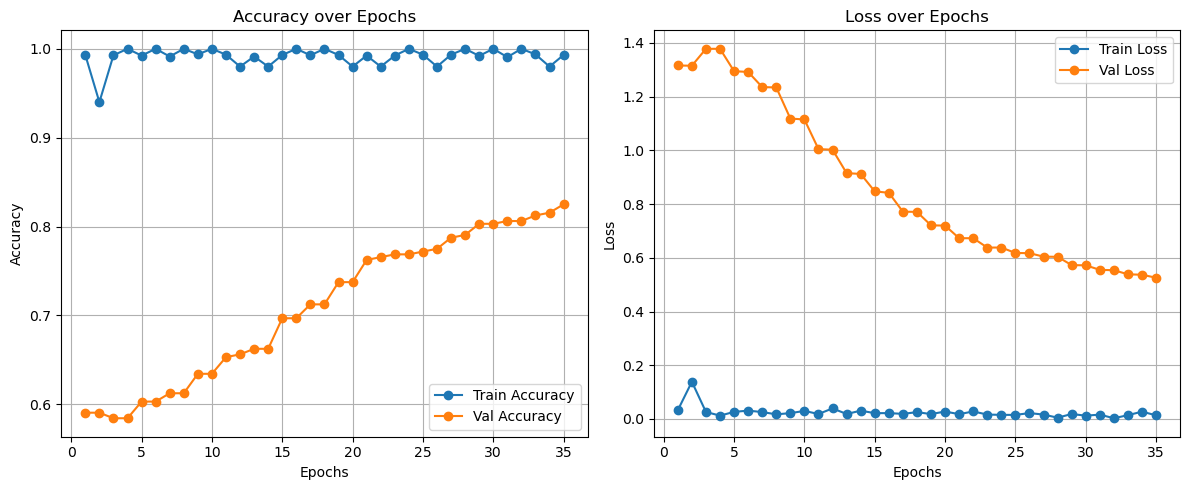


Epoch 35: val_loss improved from 0.53689 to 0.52580, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.0084 - precision_2: 0.9967 - recall_2: 0.9964 - val_accuracy: 0.8250 - val_auc: 0.9672 - val_loss: 0.5258 - val_precision_2: 0.8618 - val_recall_2: 0.8188
Epoch 36/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0557 - precision_2: 0.9600 - recall_2: 0.9600Epoch 36: Train Accuracy: 0.9600, Val Accuracy: 0.8250, Train Loss: 0.0557, Val Loss: 0.5242

Epoch 36: val_loss improved from 0.52580 to 0.52419, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0557 - precision_2: 0.9600 - recall_2: 0.9600 - val_accuracy: 0.8250 - val_auc: 0.9673 - val_loss: 0.5242 - val_precision_2: 0.8675 - val_recall_2: 0.8188
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0059 - precision_2: 0

2024-12-03 22:43:31.816274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 39: Train Accuracy: 0.9917, Val Accuracy: 0.8406, Train Loss: 0.0145, Val Loss: 0.5152

Epoch 39: val_loss improved from 0.51921 to 0.51525, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9965 - auc: 1.0000 - loss: 0.0079 - precision_2: 0.9966 - recall_2: 0.9963 - val_accuracy: 0.8406 - val_auc: 0.9678 - val_loss: 0.5152 - val_precision_2: 0.8656 - val_recall_2: 0.8250
Epoch 40/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0186 - precision_2: 0.9800 - recall_2: 0.9800Epoch 40: Train Accuracy: 0.9800, Val Accuracy: 0.8406, Train Loss: 0.0186, Val Loss: 0.5152


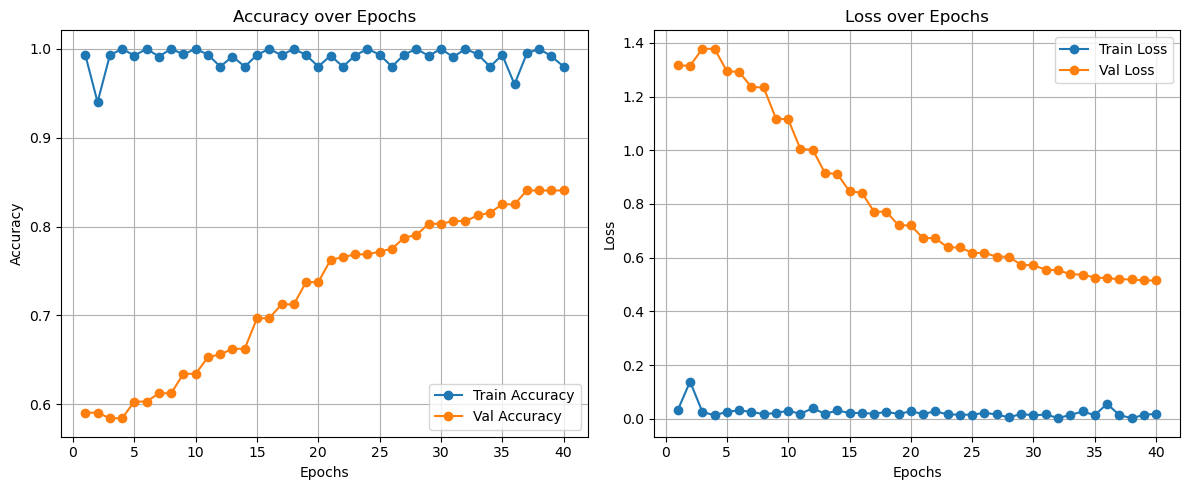


Epoch 40: val_loss improved from 0.51525 to 0.51517, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0186 - precision_2: 0.9800 - recall_2: 0.9800 - val_accuracy: 0.8406 - val_auc: 0.9676 - val_loss: 0.5152 - val_precision_2: 0.8656 - val_recall_2: 0.8250
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9967 - auc: 1.0000 - loss: 0.0080 - precision_2: 0.9967 - recall_2: 0.9965Epoch 41: Train Accuracy: 0.9927, Val Accuracy: 0.8469, Train Loss: 0.0140, Val Loss: 0.5042

Epoch 41: val_loss improved from 0.51517 to 0.50416, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9966 - auc: 1.0000 - loss: 0.0081 - precision_2: 0.9967 - recall_2: 0.9964 - val_accuracy: 0.8469 - val_auc: 0.9687 - val_loss: 0.5042 - val_precision_2: 0.8660 - val_recall_2: 0.8281
Epoch 42/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0377 - precision_2: 0.

2024-12-03 22:43:44.882414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 44: Train Accuracy: 0.9600, Val Accuracy: 0.8562, Train Loss: 0.0606, Val Loss: 0.4851

Epoch 44: val_loss improved from 0.48546 to 0.48514, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0606 - precision_2: 0.9600 - recall_2: 0.9600 - val_accuracy: 0.8562 - val_auc: 0.9702 - val_loss: 0.4851 - val_precision_2: 0.8677 - val_recall_2: 0.8406
Epoch 45/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9952 - auc: 1.0000 - loss: 0.0083 - precision_2: 0.9955 - recall_2: 0.9952Epoch 45: Train Accuracy: 0.9906, Val Accuracy: 0.8469, Train Loss: 0.0149, Val Loss: 0.5037


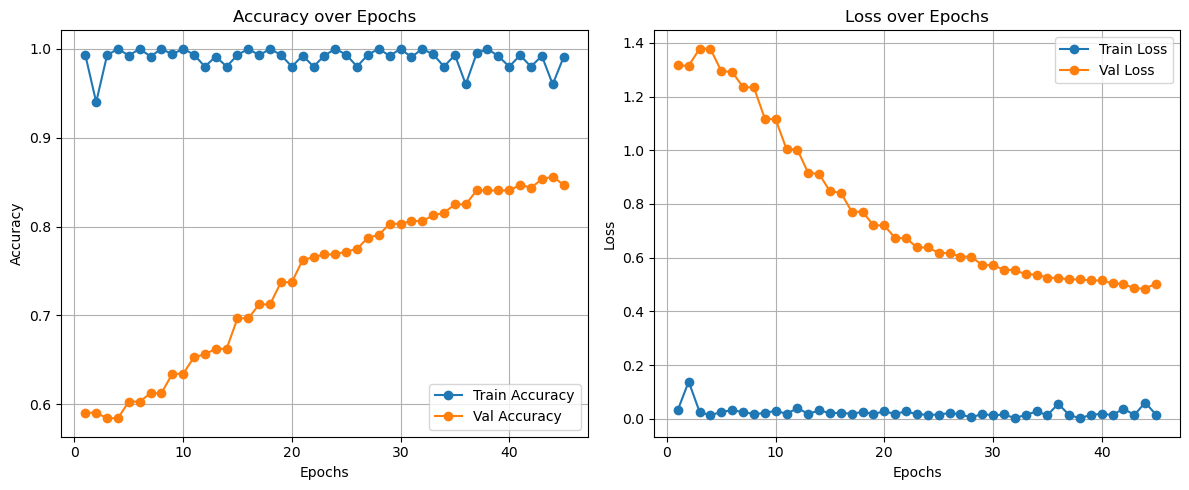


Epoch 45: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9951 - auc: 1.0000 - loss: 0.0085 - precision_2: 0.9954 - recall_2: 0.9951 - val_accuracy: 0.8469 - val_auc: 0.9689 - val_loss: 0.5037 - val_precision_2: 0.8622 - val_recall_2: 0.8406
Epoch 46/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0264 - precision_2: 0.9800 - recall_2: 0.9800

2024-12-03 22:43:50.736192: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 46: Train Accuracy: 0.9800, Val Accuracy: 0.8469, Train Loss: 0.0264, Val Loss: 0.5040

Epoch 46: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0264 - precision_2: 0.9800 - recall_2: 0.9800 - val_accuracy: 0.8469 - val_auc: 0.9689 - val_loss: 0.5040 - val_precision_2: 0.8622 - val_recall_2: 0.8406
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9972 - auc: 1.0000 - loss: 0.0076 - precision_2: 0.9972 - recall_2: 0.9967

2024-12-03 22:43:55.434027: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 47: Train Accuracy: 0.9934, Val Accuracy: 0.8500, Train Loss: 0.0131, Val Loss: 0.5077

Epoch 47: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9971 - auc: 1.0000 - loss: 0.0077 - precision_2: 0.9971 - recall_2: 0.9966 - val_accuracy: 0.8500 - val_auc: 0.9679 - val_loss: 0.5077 - val_precision_2: 0.8662 - val_recall_2: 0.8500
Epoch 48/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0051 - precision_2: 1.0000 - recall_2: 1.0000

2024-12-03 22:43:55.809844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 48: Train Accuracy: 1.0000, Val Accuracy: 0.8500, Train Loss: 0.0051, Val Loss: 0.5088

Epoch 48: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0051 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8500 - val_auc: 0.9680 - val_loss: 0.5088 - val_precision_2: 0.8631 - val_recall_2: 0.8469
Epoch 49/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9968 - auc: 1.0000 - loss: 0.0085 - precision_2: 0.9968 - recall_2: 0.9967Epoch 49: Train Accuracy: 0.9924, Val Accuracy: 0.8500, Train Loss: 0.0147, Val Loss: 0.5308

Epoch 49: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9967 - auc: 1.0000 - loss: 0.0086 - precision_2: 0.9967 - recall_2: 0.9966 - val_accuracy: 0.8500 - val_auc: 0.9669 - val_loss: 0.5308 - val_precision_2: 0.8603 - val_recall_2: 0.8469
Epoch 50/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0015 -

2024-12-03 22:44:00.905995: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 50: Train Accuracy: 1.0000, Val Accuracy: 0.8500, Train Loss: 0.0015, Val Loss: 0.5317


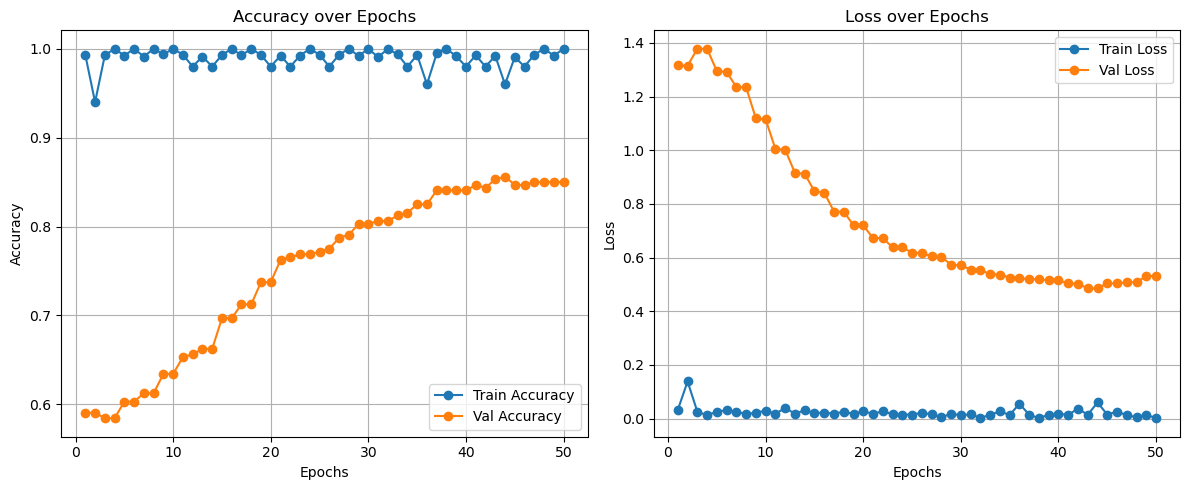


Epoch 50: val_loss did not improve from 0.48514
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0015 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.8500 - val_auc: 0.9669 - val_loss: 0.5317 - val_precision_2: 0.8603 - val_recall_2: 0.8469


In [17]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.00001  

model.compile(
optimizer=Adam(learning_rate=0.00001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


In [18]:
for layer in model.layers[-20:]:
    layer.trainable = True


Resuming training with a learning rate of 1e-06
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0054 - precision_3: 0.9986 - recall_3: 0.9976Epoch 1: Train Accuracy: 0.9937, Val Accuracy: 0.8531, Train Loss: 0.0126, Val Loss: 0.5271

Epoch 1: val_loss improved from inf to 0.52706, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0056 - precision_3: 0.9985 - recall_3: 0.9975 - val_accuracy: 0.8531 - val_auc: 0.9676 - val_loss: 0.5271 - val_precision_3: 0.8603 - val_recall_3: 0.8469
Epoch 2/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12:24 17s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0044 - precision_3: 1.0000 - recall_3: 1.0000Epoch 2: Train Accuracy: 1.0000, Val Accuracy: 0.8531, Train Loss: 0.0044, Val Loss: 0.5282

Epoch 2: val_loss did not improve from 0.52706
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0044 - precision_3: 1.0000 - recall

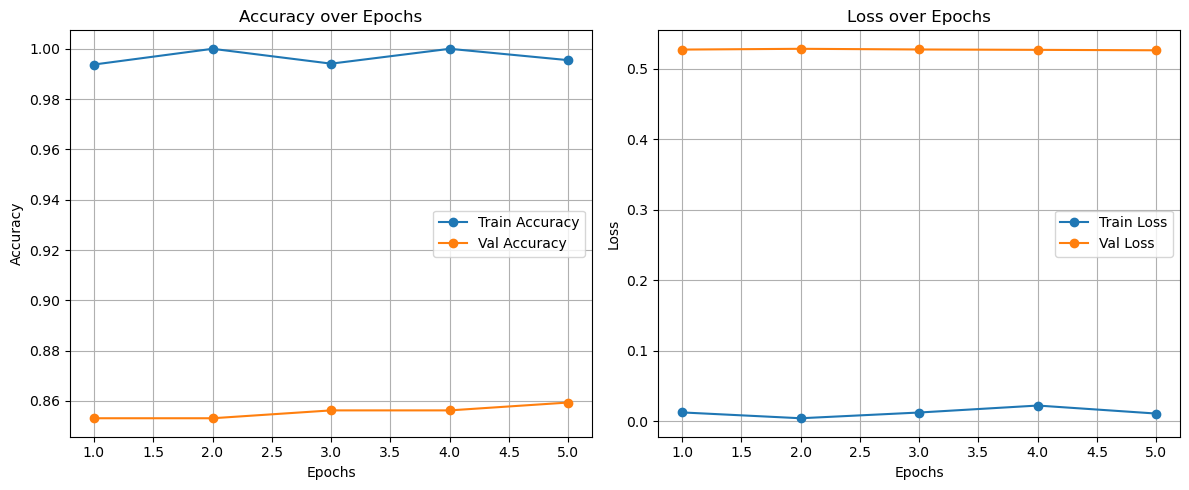


Epoch 5: val_loss improved from 0.52668 to 0.52606, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9983 - auc: 1.0000 - loss: 0.0050 - precision_3: 0.9983 - recall_3: 0.9981 - val_accuracy: 0.8594 - val_auc: 0.9681 - val_loss: 0.5261 - val_precision_3: 0.8608 - val_recall_3: 0.8500
Epoch 6/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0185 - precision_3: 0.9800 - recall_3: 0.9800Epoch 6: Train Accuracy: 0.9800, Val Accuracy: 0.8594, Train Loss: 0.0185, Val Loss: 0.5251

Epoch 6: val_loss improved from 0.52606 to 0.52514, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0185 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8594 - val_auc: 0.9682 - val_loss: 0.5251 - val_precision_3: 0.8612 - val_recall_3: 0.8531
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0060 - precision_3: 0.9982

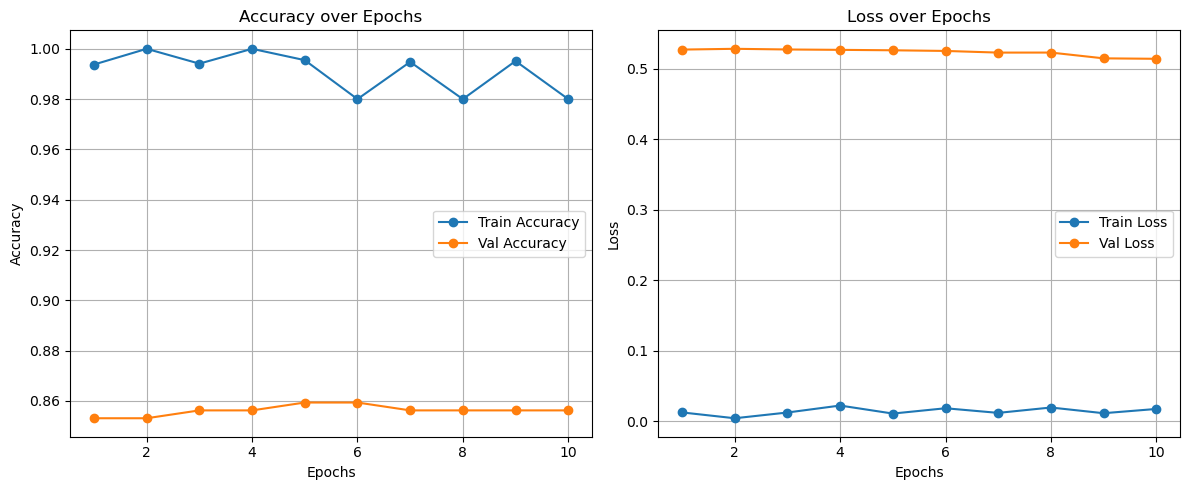


Epoch 10: val_loss improved from 0.51464 to 0.51400, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0176 - precision_3: 1.0000 - recall_3: 0.9800 - val_accuracy: 0.8562 - val_auc: 0.9682 - val_loss: 0.5140 - val_precision_3: 0.8639 - val_recall_3: 0.8531
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0059 - precision_3: 0.9978 - recall_3: 0.9977Epoch 11: Train Accuracy: 0.9948, Val Accuracy: 0.8531, Train Loss: 0.0116, Val Loss: 0.5074

Epoch 11: val_loss improved from 0.51400 to 0.50738, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0060 - precision_3: 0.9977 - recall_3: 0.9976 - val_accuracy: 0.8531 - val_auc: 0.9688 - val_loss: 0.5074 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 12/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0237 - precision_3: 0

2024-12-03 22:46:49.061438: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 14: Train Accuracy: 0.9800, Val Accuracy: 0.8562, Train Loss: 0.0221, Val Loss: 0.5028

Epoch 14: val_loss improved from 0.50299 to 0.50280, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0221 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8562 - val_auc: 0.9695 - val_loss: 0.5028 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0058 - precision_3: 0.9981 - recall_3: 0.9976Epoch 15: Train Accuracy: 0.9955, Val Accuracy: 0.8562, Train Loss: 0.0102, Val Loss: 0.4955


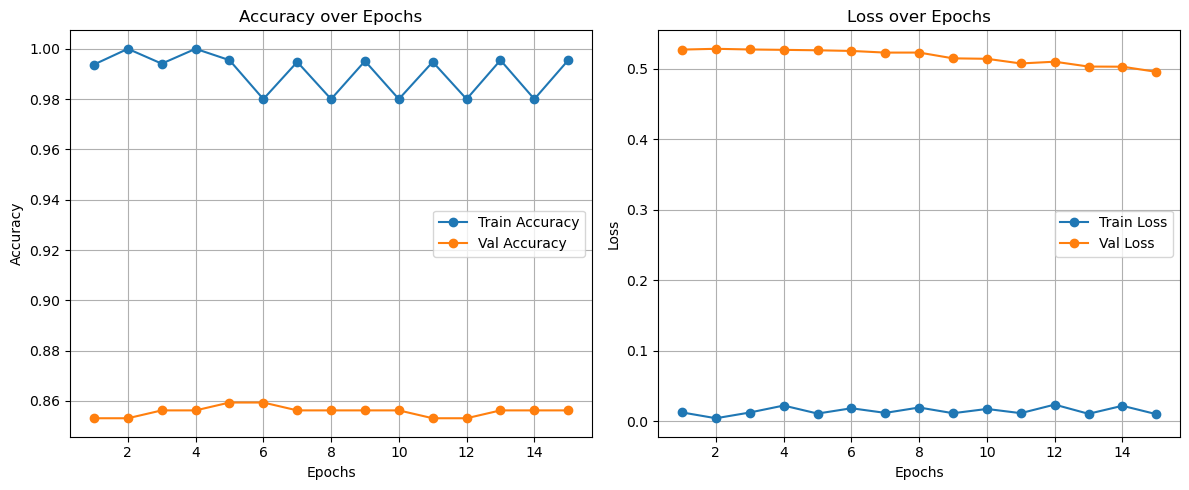


Epoch 15: val_loss improved from 0.50280 to 0.49551, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0059 - precision_3: 0.9981 - recall_3: 0.9975 - val_accuracy: 0.8562 - val_auc: 0.9700 - val_loss: 0.4955 - val_precision_3: 0.8639 - val_recall_3: 0.8531
Epoch 16/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0659 - precision_3: 0.9800 - recall_3: 0.9800Epoch 16: Train Accuracy: 0.9800, Val Accuracy: 0.8562, Train Loss: 0.0659, Val Loss: 0.4963

Epoch 16: val_loss did not improve from 0.49551
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0659 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8562 - val_auc: 0.9712 - val_loss: 0.4963 - val_precision_3: 0.8639 - val_recall_3: 0.8531
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9975 - auc: 1.0000 - loss: 0.0056 - precision_3: 0.9979 - recall_3: 0.9975

2024-12-03 22:47:01.657185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 17: Train Accuracy: 0.9934, Val Accuracy: 0.8562, Train Loss: 0.0123, Val Loss: 0.4916

Epoch 17: val_loss improved from 0.49551 to 0.49160, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0057 - precision_3: 0.9978 - recall_3: 0.9974 - val_accuracy: 0.8562 - val_auc: 0.9715 - val_loss: 0.4916 - val_precision_3: 0.8603 - val_recall_3: 0.8469
Epoch 18/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0017 - precision_3: 1.0000 - recall_3: 1.0000Epoch 18: Train Accuracy: 1.0000, Val Accuracy: 0.8562, Train Loss: 0.0017, Val Loss: 0.4923

Epoch 18: val_loss did not improve from 0.49160
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0017 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8562 - val_auc: 0.9715 - val_loss: 0.4923 - val_precision_3: 0.8603 - val_recall_3: 0.8469
Epoch 19/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accurac

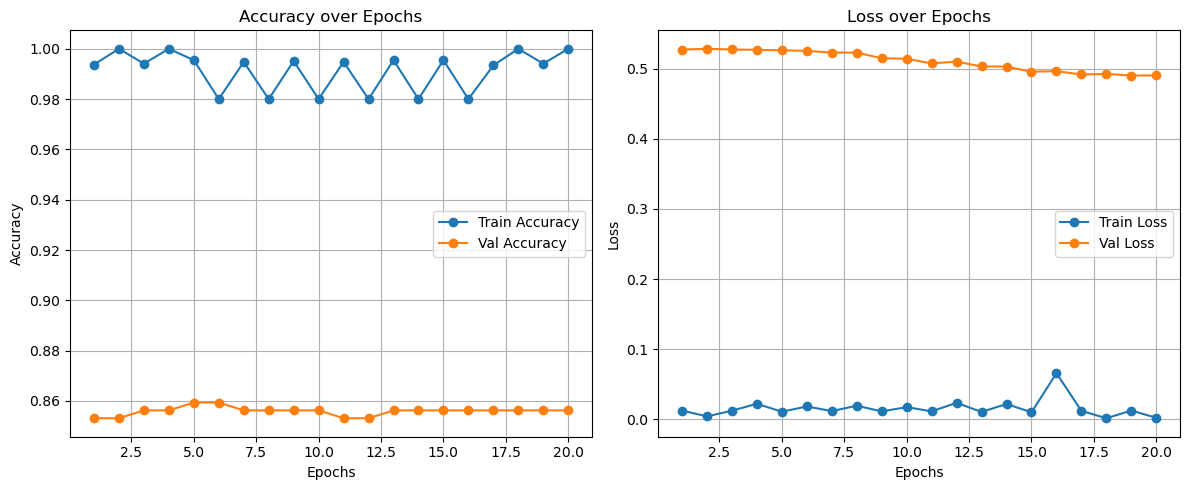


Epoch 20: val_loss did not improve from 0.49010
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0024 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8562 - val_auc: 0.9718 - val_loss: 0.4902 - val_precision_3: 0.8682 - val_recall_3: 0.8438
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0050 - precision_3: 0.9982 - recall_3: 0.9981

2024-12-03 22:47:14.948449: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 21: Train Accuracy: 0.9948, Val Accuracy: 0.8594, Train Loss: 0.0111, Val Loss: 0.4832

Epoch 21: val_loss improved from 0.49010 to 0.48318, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0051 - precision_3: 0.9981 - recall_3: 0.9980 - val_accuracy: 0.8594 - val_auc: 0.9723 - val_loss: 0.4832 - val_precision_3: 0.8658 - val_recall_3: 0.8469
Epoch 22/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0526 - precision_3: 0.9600 - recall_3: 0.9600

2024-12-03 22:47:15.965848: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 22: Train Accuracy: 0.9600, Val Accuracy: 0.8594, Train Loss: 0.0526, Val Loss: 0.4834

Epoch 22: val_loss did not improve from 0.48318
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0526 - precision_3: 0.9600 - recall_3: 0.9600 - val_accuracy: 0.8594 - val_auc: 0.9723 - val_loss: 0.4834 - val_precision_3: 0.8714 - val_recall_3: 0.8469
Epoch 23/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0060 - precision_3: 0.9980 - recall_3: 0.9978

2024-12-03 22:47:21.417798: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 23: Train Accuracy: 0.9958, Val Accuracy: 0.8594, Train Loss: 0.0105, Val Loss: 0.4742

Epoch 23: val_loss improved from 0.48318 to 0.47419, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0061 - precision_3: 0.9979 - recall_3: 0.9977 - val_accuracy: 0.8594 - val_auc: 0.9742 - val_loss: 0.4742 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 24/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0027 - precision_3: 1.0000 - recall_3: 1.0000Epoch 24: Train Accuracy: 1.0000, Val Accuracy: 0.8594, Train Loss: 0.0027, Val Loss: 0.4739

Epoch 24: val_loss improved from 0.47419 to 0.47394, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0027 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8594 - val_auc: 0.9741 - val_loss: 0.4739 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 25/50
45/45 ━━━━━

2024-12-03 22:47:28.156329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 25: Train Accuracy: 0.9944, Val Accuracy: 0.8594, Train Loss: 0.0107, Val Loss: 0.4656


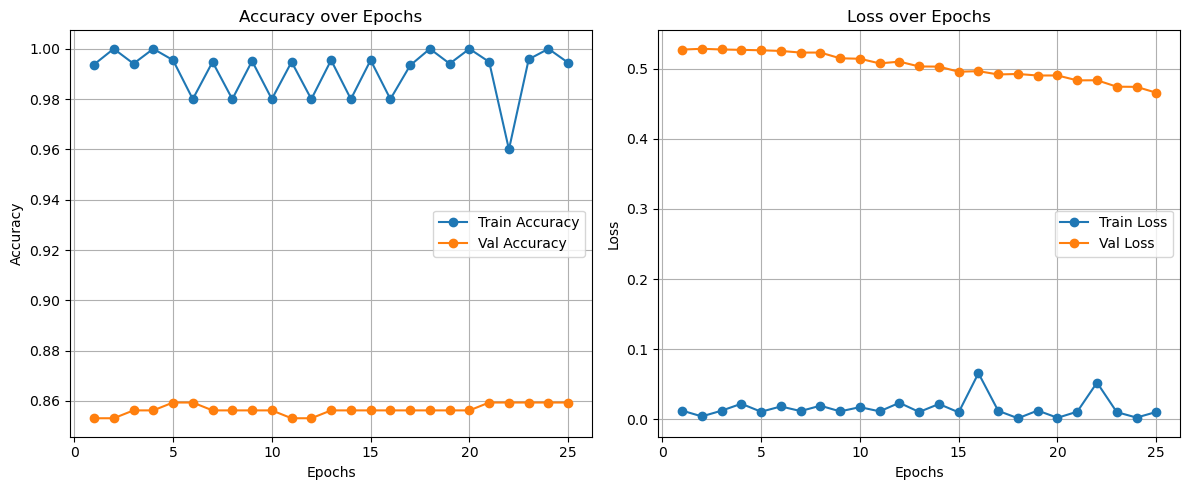


Epoch 25: val_loss improved from 0.47394 to 0.46559, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9975 - auc: 1.0000 - loss: 0.0056 - precision_3: 0.9975 - recall_3: 0.9974 - val_accuracy: 0.8594 - val_auc: 0.9732 - val_loss: 0.4656 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 26/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0203 - precision_3: 1.0000 - recall_3: 1.0000Epoch 26: Train Accuracy: 1.0000, Val Accuracy: 0.8594, Train Loss: 0.0203, Val Loss: 0.4657

Epoch 26: val_loss did not improve from 0.46559
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0203 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8594 - val_auc: 0.9732 - val_loss: 0.4657 - val_precision_3: 0.8667 - val_recall_3: 0.8531
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0060 - precision_3: 0.9974 - recall_3: 0.9974Epoch 27: Train

2024-12-03 22:47:36.135300: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


Epoch 28: Train Accuracy: 0.9800, Val Accuracy: 0.8562, Train Loss: 0.0192, Val Loss: 0.4599

Epoch 28: val_loss did not improve from 0.45767
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0192 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8562 - val_auc: 0.9762 - val_loss: 0.4599 - val_precision_3: 0.8694 - val_recall_3: 0.8531
Epoch 29/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0062 - precision_3: 0.9980 - recall_3: 0.9978

2024-12-03 22:47:41.098348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 29: Train Accuracy: 0.9944, Val Accuracy: 0.8562, Train Loss: 0.0110, Val Loss: 0.4531

Epoch 29: val_loss improved from 0.45767 to 0.45309, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0063 - precision_3: 0.9980 - recall_3: 0.9977 - val_accuracy: 0.8562 - val_auc: 0.9751 - val_loss: 0.4531 - val_precision_3: 0.8690 - val_recall_3: 0.8500
Epoch 30/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0207 - precision_3: 0.9800 - recall_3: 0.9800

2024-12-03 22:47:42.152676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 30: Train Accuracy: 0.9800, Val Accuracy: 0.8562, Train Loss: 0.0207, Val Loss: 0.4515


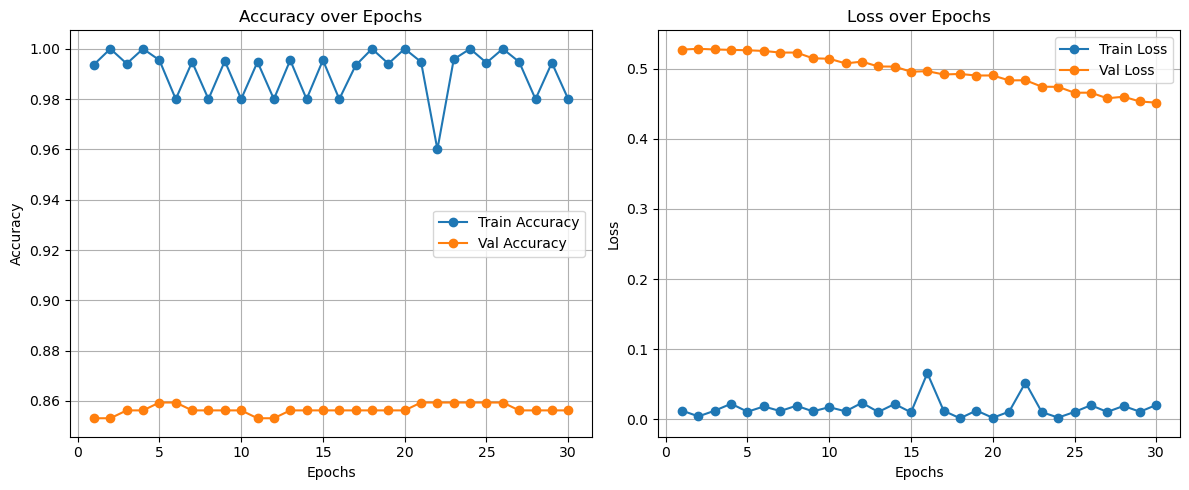


Epoch 30: val_loss improved from 0.45309 to 0.45146, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0207 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8562 - val_auc: 0.9752 - val_loss: 0.4515 - val_precision_3: 0.8690 - val_recall_3: 0.8500
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9986 - auc: 1.0000 - loss: 0.0056 - precision_3: 0.9986 - recall_3: 0.9979Epoch 31: Train Accuracy: 0.9958, Val Accuracy: 0.8625, Train Loss: 0.0108, Val Loss: 0.4467

Epoch 31: val_loss improved from 0.45146 to 0.44666, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9985 - auc: 1.0000 - loss: 0.0058 - precision_3: 0.9985 - recall_3: 0.9979 - val_accuracy: 0.8625 - val_auc: 0.9754 - val_loss: 0.4467 - val_precision_3: 0.8778 - val_recall_3: 0.8531
Epoch 32/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0107 - precision_3: 1

2024-12-03 22:47:49.031401: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 32: Train Accuracy: 1.0000, Val Accuracy: 0.8625, Train Loss: 0.0107, Val Loss: 0.4459

Epoch 32: val_loss improved from 0.44666 to 0.44592, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0107 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8625 - val_auc: 0.9754 - val_loss: 0.4459 - val_precision_3: 0.8778 - val_recall_3: 0.8531
Epoch 33/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0060 - precision_3: 0.9991 - recall_3: 0.9986Epoch 33: Train Accuracy: 0.9962, Val Accuracy: 0.8625, Train Loss: 0.0103, Val Loss: 0.4386

Epoch 33: val_loss improved from 0.44592 to 0.43860, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0061 - precision_3: 0.9990 - recall_3: 0.9986 - val_accuracy: 0.8625 - val_auc: 0.9759 - val_loss: 0.4386 - val_precision_3: 0.8810 - val_recall_3: 0.8562
Epoch 34/50
 1/45 ━━━━━

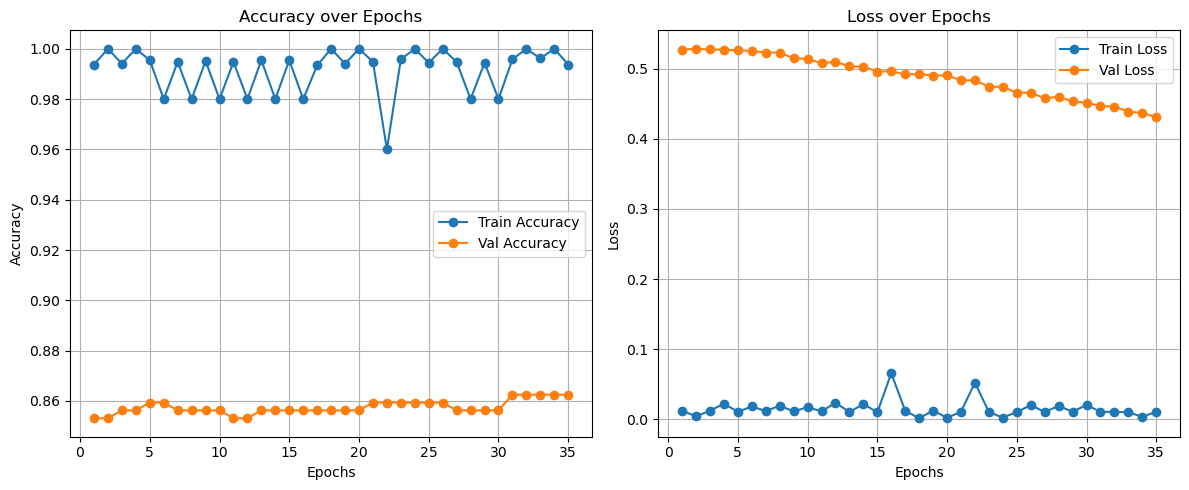


Epoch 35: val_loss improved from 0.43694 to 0.43067, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0051 - precision_3: 0.9980 - recall_3: 0.9980 - val_accuracy: 0.8625 - val_auc: 0.9762 - val_loss: 0.4307 - val_precision_3: 0.8839 - val_recall_3: 0.8562
Epoch 36/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0428 - precision_3: 0.9800 - recall_3: 0.9800Epoch 36: Train Accuracy: 0.9800, Val Accuracy: 0.8625, Train Loss: 0.0428, Val Loss: 0.4301

Epoch 36: val_loss improved from 0.43067 to 0.43015, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0428 - precision_3: 0.9800 - recall_3: 0.9800 - val_accuracy: 0.8625 - val_auc: 0.9762 - val_loss: 0.4301 - val_precision_3: 0.8867 - val_recall_3: 0.8562
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0067 - precision_3: 0

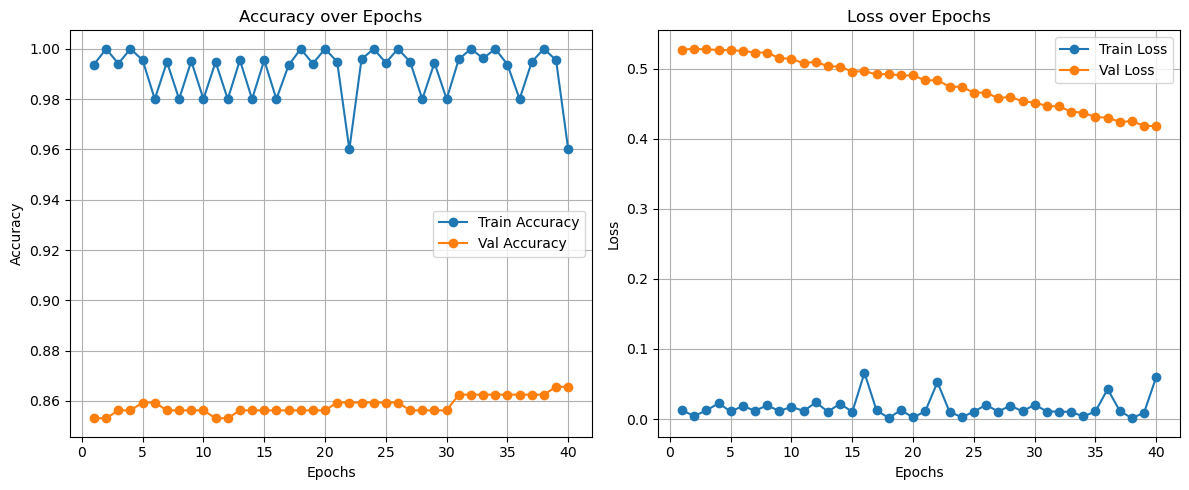


Epoch 40: val_loss improved from 0.41814 to 0.41798, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9600 - auc: 0.9994 - loss: 0.0604 - precision_3: 0.9600 - recall_3: 0.9600 - val_accuracy: 0.8656 - val_auc: 0.9768 - val_loss: 0.4180 - val_precision_3: 0.8782 - val_recall_3: 0.8562
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9970 - auc: 1.0000 - loss: 0.0081 - precision_3: 0.9970 - recall_3: 0.9969Epoch 41: Train Accuracy: 0.9951, Val Accuracy: 0.8719, Train Loss: 0.0121, Val Loss: 0.4145

Epoch 41: val_loss improved from 0.41798 to 0.41450, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9970 - auc: 1.0000 - loss: 0.0082 - precision_3: 0.9970 - recall_3: 0.9968 - val_accuracy: 0.8719 - val_auc: 0.9759 - val_loss: 0.4145 - val_precision_3: 0.8786 - val_recall_3: 0.8594
Epoch 42/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0076 - precision_3: 1

2024-12-03 22:48:34.450190: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 45: Train Accuracy: 0.9951, Val Accuracy: 0.8781, Train Loss: 0.0114, Val Loss: 0.4072


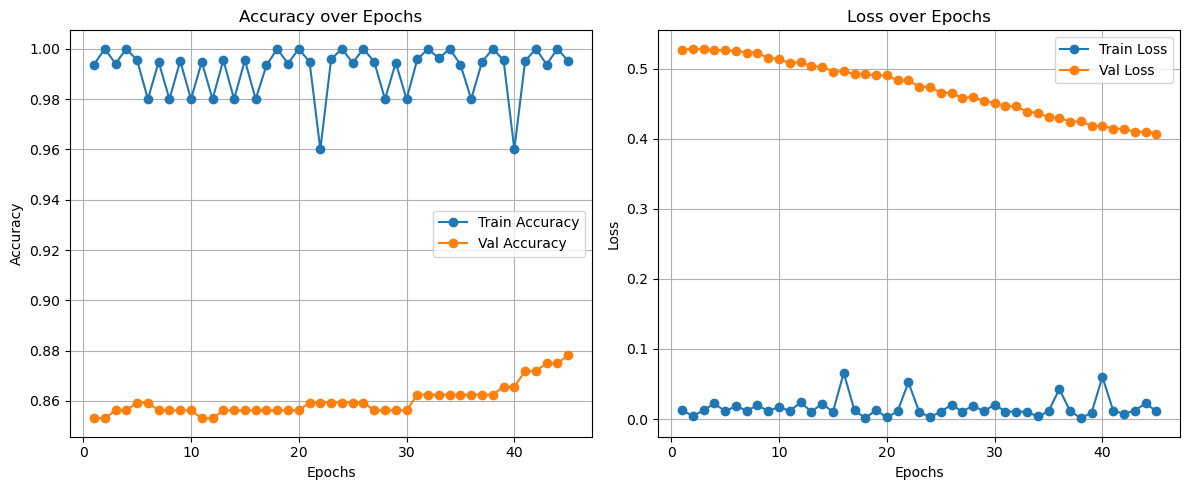


Epoch 45: val_loss improved from 0.40976 to 0.40725, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9986 - auc: 1.0000 - loss: 0.0054 - precision_3: 0.9986 - recall_3: 0.9986 - val_accuracy: 0.8781 - val_auc: 0.9766 - val_loss: 0.4072 - val_precision_3: 0.8907 - val_recall_3: 0.8656
Epoch 46/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0051 - precision_3: 1.0000 - recall_3: 1.0000Epoch 46: Train Accuracy: 1.0000, Val Accuracy: 0.8781, Train Loss: 0.0051, Val Loss: 0.4072

Epoch 46: val_loss improved from 0.40725 to 0.40721, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0051 - precision_3: 1.0000 - recall_3: 1.0000 - val_accuracy: 0.8781 - val_auc: 0.9752 - val_loss: 0.4072 - val_precision_3: 0.8907 - val_recall_3: 0.8656
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9971 - auc: 1.0000 - loss: 0.0063 - precision_3: 0

2024-12-03 22:48:49.592636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 49: Train Accuracy: 0.9955, Val Accuracy: 0.8906, Train Loss: 0.0101, Val Loss: 0.4045

Epoch 49: val_loss improved from 0.40679 to 0.40447, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9974 - auc: 1.0000 - loss: 0.0061 - precision_3: 0.9976 - recall_3: 0.9974 - val_accuracy: 0.8906 - val_auc: 0.9746 - val_loss: 0.4045 - val_precision_3: 0.8949 - val_recall_3: 0.8781
Epoch 50/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9600 - auc: 0.9992 - loss: 0.0576 - precision_3: 0.9600 - recall_3: 0.9600Epoch 50: Train Accuracy: 0.9600, Val Accuracy: 0.8844, Train Loss: 0.0576, Val Loss: 0.4051


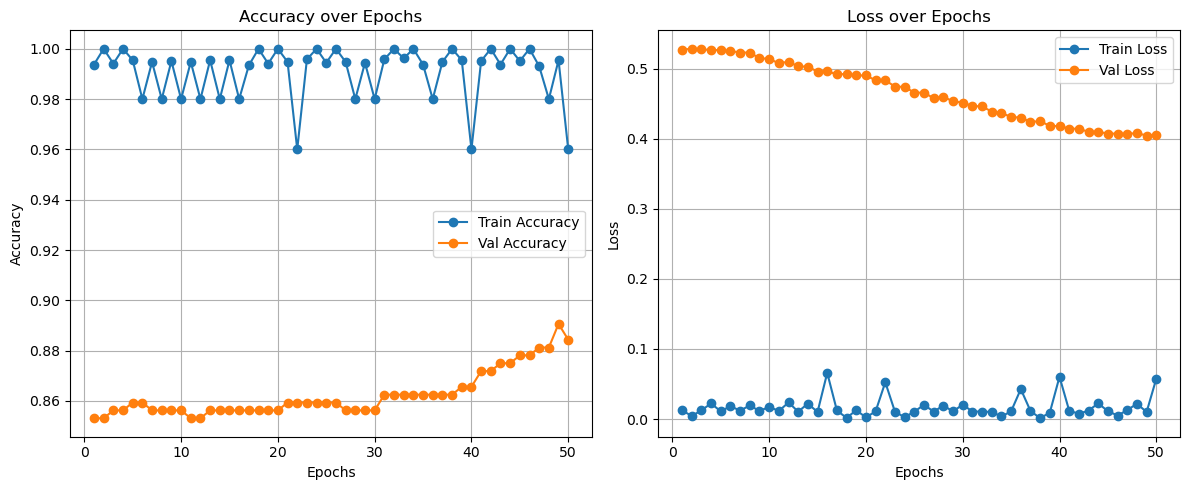


Epoch 50: val_loss did not improve from 0.40447
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9600 - auc: 0.9992 - loss: 0.0576 - precision_3: 0.9600 - recall_3: 0.9600 - val_accuracy: 0.8844 - val_auc: 0.9745 - val_loss: 0.4051 - val_precision_3: 0.8952 - val_recall_3: 0.8813


In [19]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.000001  

model.compile(
optimizer=Adam(learning_rate=0.000001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


Resuming training with a learning rate of 1e-07
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0053 - precision_4: 0.9983 - recall_4: 0.9975Epoch 1: Train Accuracy: 0.9944, Val Accuracy: 0.8875, Train Loss: 0.0109, Val Loss: 0.4026

Epoch 1: val_loss improved from inf to 0.40260, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0054 - precision_4: 0.9982 - recall_4: 0.9974 - val_accuracy: 0.8875 - val_auc: 0.9747 - val_loss: 0.4026 - val_precision_4: 0.8917 - val_recall_4: 0.8750
Epoch 2/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12:46 17s/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0239 - precision_4: 0.9800 - recall_4: 0.9800

/home/ritika/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: Train Accuracy: 0.9800, Val Accuracy: 0.8875, Train Loss: 0.0239, Val Loss: 0.4033

Epoch 2: val_loss did not improve from 0.40260
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0239 - precision_4: 0.9800 - recall_4: 0.9800 - val_accuracy: 0.8875 - val_auc: 0.9747 - val_loss: 0.4033 - val_precision_4: 0.8952 - val_recall_4: 0.8813
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9977 - auc: 1.0000 - loss: 0.0048 - precision_4: 0.9978 - recall_4: 0.9976

2024-12-03 22:51:13.433577: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 3: Train Accuracy: 0.9948, Val Accuracy: 0.8875, Train Loss: 0.0103, Val Loss: 0.4000

Epoch 3: val_loss improved from 0.40260 to 0.40002, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9976 - auc: 1.0000 - loss: 0.0049 - precision_4: 0.9978 - recall_4: 0.9975 - val_accuracy: 0.8875 - val_auc: 0.9751 - val_loss: 0.4000 - val_precision_4: 0.8952 - val_recall_4: 0.8813
Epoch 4/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0324 - precision_4: 0.9600 - recall_4: 0.9600Epoch 4: Train Accuracy: 0.9600, Val Accuracy: 0.8906, Train Loss: 0.0324, Val Loss: 0.3995

Epoch 4: val_loss improved from 0.40002 to 0.39953, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0324 - precision_4: 0.9600 - recall_4: 0.9600 - val_accuracy: 0.8906 - val_auc: 0.9749 - val_loss: 0.3995 - val_precision_4: 0.9013 - val_recall_4: 0.8844
Epoch 5/50
45/45 ━━━━━━━━━━━

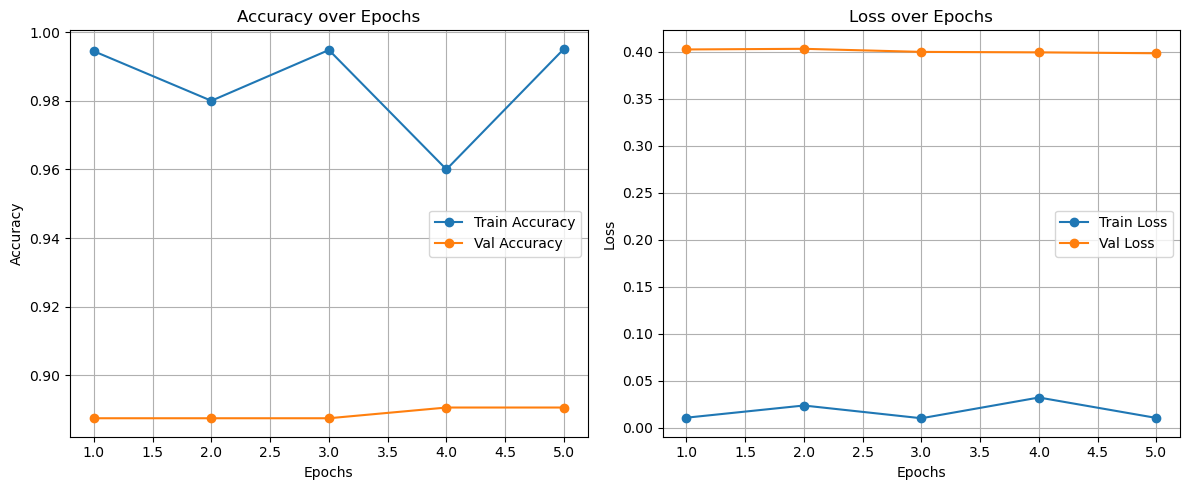


Epoch 5: val_loss improved from 0.39953 to 0.39856, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0051 - precision_4: 0.9983 - recall_4: 0.9981 - val_accuracy: 0.8906 - val_auc: 0.9752 - val_loss: 0.3986 - val_precision_4: 0.9016 - val_recall_4: 0.8875
Epoch 6/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0385 - precision_4: 0.9800 - recall_4: 0.9800Epoch 6: Train Accuracy: 0.9800, Val Accuracy: 0.8906, Train Loss: 0.0385, Val Loss: 0.3995

Epoch 6: val_loss did not improve from 0.39856
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0385 - precision_4: 0.9800 - recall_4: 0.9800 - val_accuracy: 0.8906 - val_auc: 0.9751 - val_loss: 0.3995 - val_precision_4: 0.9016 - val_recall_4: 0.8875
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0045 - precision_4: 0.9984 - recall_4: 0.9982Epoch 7: Train Accur

2024-12-03 22:51:27.195306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8077780752843956587
2024-12-03 22:51:27.195422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5266844873620398561


Epoch 8: Train Accuracy: 1.0000, Val Accuracy: 0.8938, Train Loss: 0.0069, Val Loss: 0.3953

Epoch 8: val_loss did not improve from 0.39505
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0069 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.8938 - val_auc: 0.9756 - val_loss: 0.3953 - val_precision_4: 0.9016 - val_recall_4: 0.8875
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0046 - precision_4: 0.9983 - recall_4: 0.9981Epoch 9: Train Accuracy: 0.9944, Val Accuracy: 0.8969, Train Loss: 0.0100, Val Loss: 0.3927

Epoch 9: val_loss improved from 0.39505 to 0.39272, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0047 - precision_4: 0.9982 - recall_4: 0.9981 - val_accuracy: 0.8969 - val_auc: 0.9758 - val_loss: 0.3927 - val_precision_4: 0.9048 - val_recall_4: 0.8906
Epoch 10/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9

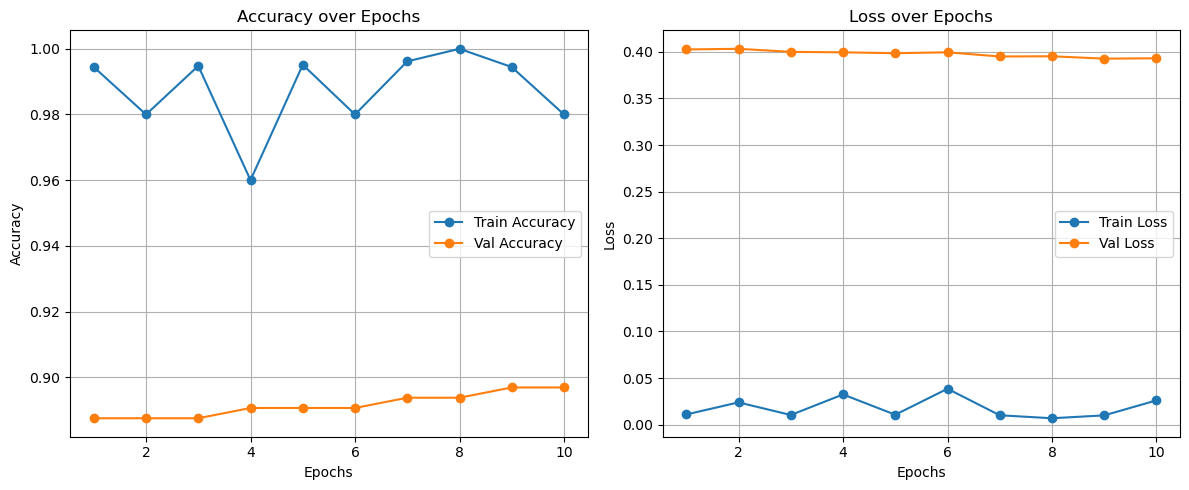


Epoch 10: val_loss did not improve from 0.39272
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0260 - precision_4: 1.0000 - recall_4: 0.9800 - val_accuracy: 0.8969 - val_auc: 0.9758 - val_loss: 0.3931 - val_precision_4: 0.9051 - val_recall_4: 0.8938
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0056 - precision_4: 0.9979 - recall_4: 0.9979Epoch 11: Train Accuracy: 0.9958, Val Accuracy: 0.8938, Train Loss: 0.0107, Val Loss: 0.3923

Epoch 11: val_loss improved from 0.39272 to 0.39230, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0058 - precision_4: 0.9979 - recall_4: 0.9978 - val_accuracy: 0.8938 - val_auc: 0.9758 - val_loss: 0.3923 - val_precision_4: 0.9022 - val_recall_4: 0.8938
Epoch 12/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0029 - precision_4: 1.0000 - recall_4: 1.0000Epoch 12: Trai

2024-12-03 22:51:44.720944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 13: Train Accuracy: 0.9948, Val Accuracy: 0.8938, Train Loss: 0.0113, Val Loss: 0.3871

Epoch 13: val_loss improved from 0.39230 to 0.38706, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9983 - auc: 1.0000 - loss: 0.0051 - precision_4: 0.9985 - recall_4: 0.9983 - val_accuracy: 0.8938 - val_auc: 0.9776 - val_loss: 0.3871 - val_precision_4: 0.9022 - val_recall_4: 0.8938
Epoch 14/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - precision_4: 1.0000 - recall_4: 1.0000Epoch 14: Train Accuracy: 1.0000, Val Accuracy: 0.8938, Train Loss: 0.0013, Val Loss: 0.3873

Epoch 14: val_loss did not improve from 0.38706
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0013 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.8938 - val_auc: 0.9790 - val_loss: 0.3873 - val_precision_4: 0.9022 - val_recall_4: 0.8938
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accurac

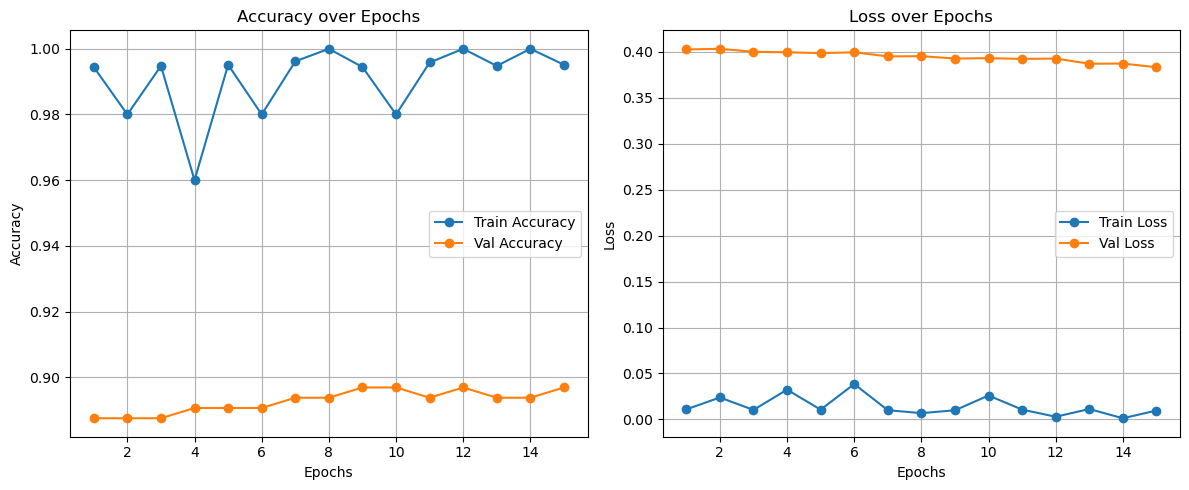


Epoch 15: val_loss improved from 0.38706 to 0.38325, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9979 - auc: 1.0000 - loss: 0.0047 - precision_4: 0.9979 - recall_4: 0.9979 - val_accuracy: 0.8969 - val_auc: 0.9778 - val_loss: 0.3833 - val_precision_4: 0.9025 - val_recall_4: 0.8969
Epoch 16/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0223 - precision_4: 1.0000 - recall_4: 1.0000Epoch 16: Train Accuracy: 1.0000, Val Accuracy: 0.8969, Train Loss: 0.0223, Val Loss: 0.3839

Epoch 16: val_loss did not improve from 0.38325
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0223 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.8969 - val_auc: 0.9792 - val_loss: 0.3839 - val_precision_4: 0.9025 - val_recall_4: 0.8969
Epoch 17/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0068 - precision_4: 0.9981 - recall_4: 0.9981Epoch 17: Train

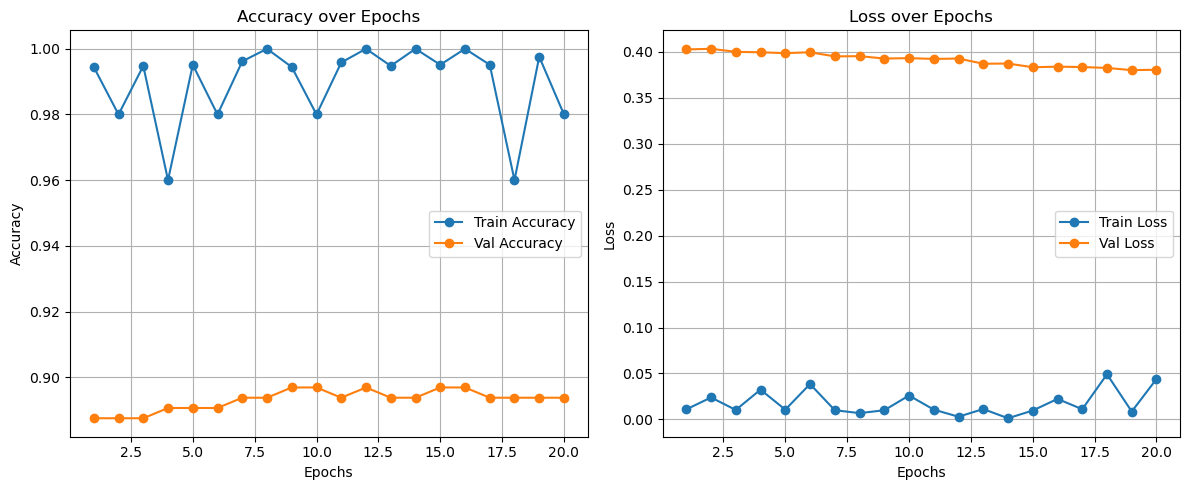


Epoch 20: val_loss did not improve from 0.38007
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0440 - precision_4: 0.9796 - recall_4: 0.9600 - val_accuracy: 0.8938 - val_auc: 0.9794 - val_loss: 0.3805 - val_precision_4: 0.8966 - val_recall_4: 0.8938
Epoch 21/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0052 - precision_4: 0.9984 - recall_4: 0.9983Epoch 21: Train Accuracy: 0.9965, Val Accuracy: 0.8969, Train Loss: 0.0097, Val Loss: 0.3783

Epoch 21: val_loss improved from 0.38007 to 0.37833, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0053 - precision_4: 0.9984 - recall_4: 0.9982 - val_accuracy: 0.8969 - val_auc: 0.9780 - val_loss: 0.3783 - val_precision_4: 0.8997 - val_recall_4: 0.8969
Epoch 22/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0155 - precision_4: 1.0000 - recall_4: 0.9800Epoch 22: Trai

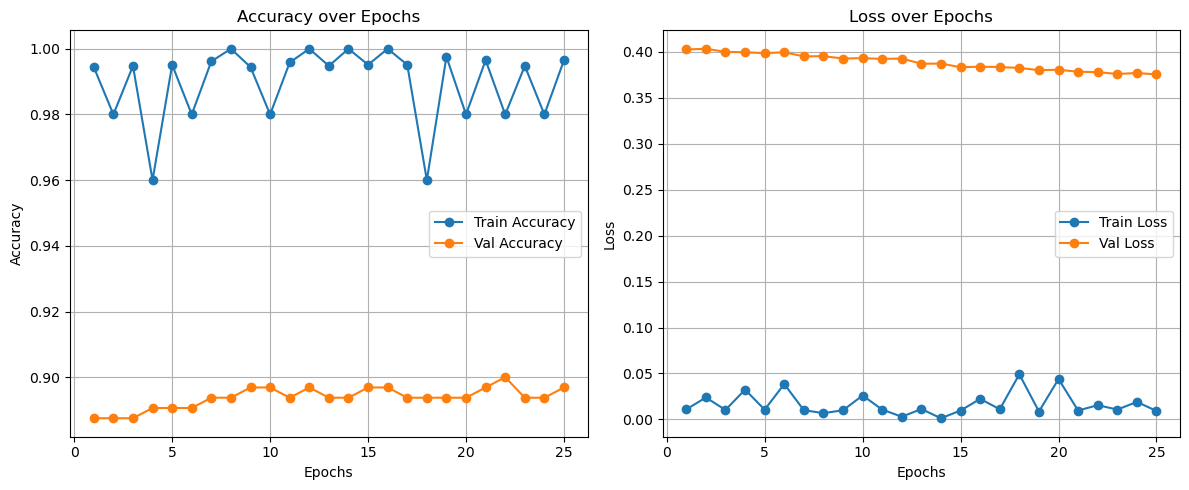


Epoch 25: val_loss improved from 0.37590 to 0.37543, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0047 - precision_4: 0.9988 - recall_4: 0.9987 - val_accuracy: 0.8969 - val_auc: 0.9810 - val_loss: 0.3754 - val_precision_4: 0.9025 - val_recall_4: 0.8969
Epoch 26/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0272 - precision_4: 1.0000 - recall_4: 1.0000Epoch 26: Train Accuracy: 1.0000, Val Accuracy: 0.8969, Train Loss: 0.0272, Val Loss: 0.3753

Epoch 26: val_loss improved from 0.37543 to 0.37530, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0272 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.8969 - val_auc: 0.9809 - val_loss: 0.3753 - val_precision_4: 0.8997 - val_recall_4: 0.8969
Epoch 27/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0055 - precision_4: 0

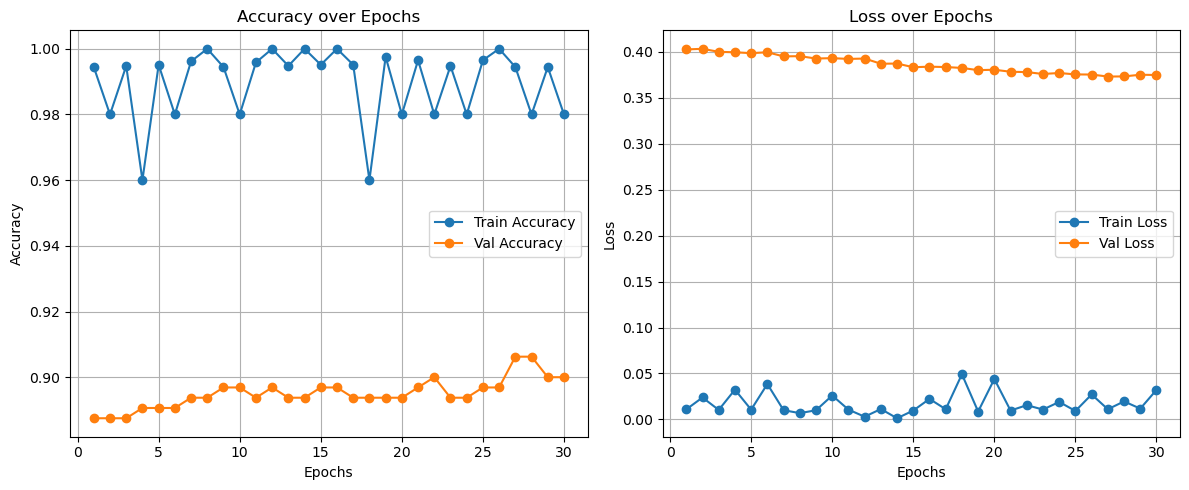


Epoch 30: val_loss did not improve from 0.37310
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0322 - precision_4: 0.9800 - recall_4: 0.9800 - val_accuracy: 0.9000 - val_auc: 0.9813 - val_loss: 0.3748 - val_precision_4: 0.9082 - val_recall_4: 0.8969
Epoch 31/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9965 - auc: 1.0000 - loss: 0.0072 - precision_4: 0.9967 - recall_4: 0.9960Epoch 31: Train Accuracy: 0.9934, Val Accuracy: 0.9031, Train Loss: 0.0120, Val Loss: 0.3736

Epoch 31: val_loss did not improve from 0.37310
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9964 - auc: 1.0000 - loss: 0.0073 - precision_4: 0.9966 - recall_4: 0.9960 - val_accuracy: 0.9031 - val_auc: 0.9814 - val_loss: 0.3736 - val_precision_4: 0.9088 - val_recall_4: 0.9031
Epoch 32/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9800 - auc: 0.9997 - loss: 0.0309 - precision_4: 0.9800 - recall_4: 0.9800Epoch 32: Train Accuracy: 0.9800, Val Accuracy: 0.90

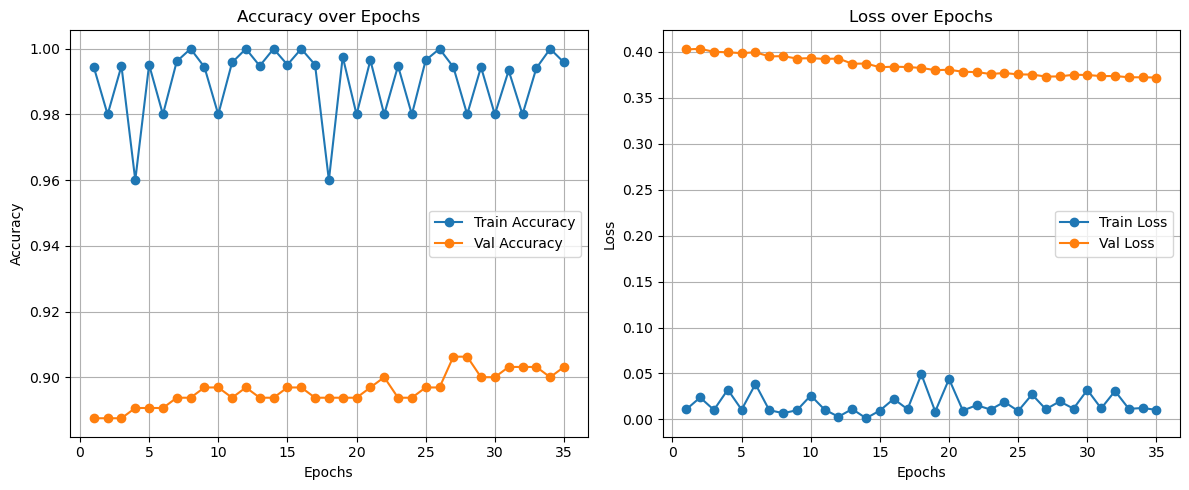


Epoch 35: val_loss improved from 0.37229 to 0.37207, saving model to best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9987 - auc: 1.0000 - loss: 0.0060 - precision_4: 0.9987 - recall_4: 0.9987 - val_accuracy: 0.9031 - val_auc: 0.9801 - val_loss: 0.3721 - val_precision_4: 0.9088 - val_recall_4: 0.9031
Epoch 36/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0294 - precision_4: 0.9800 - recall_4: 0.9800Epoch 36: Train Accuracy: 0.9800, Val Accuracy: 0.9062, Train Loss: 0.0294, Val Loss: 0.3730

Epoch 36: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0294 - precision_4: 0.9800 - recall_4: 0.9800 - val_accuracy: 0.9062 - val_auc: 0.9800 - val_loss: 0.3730 - val_precision_4: 0.9117 - val_recall_4: 0.9031
Epoch 37/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0047 - precision_4: 0.9984 - recall_4: 0.9984Epoch 37: Train

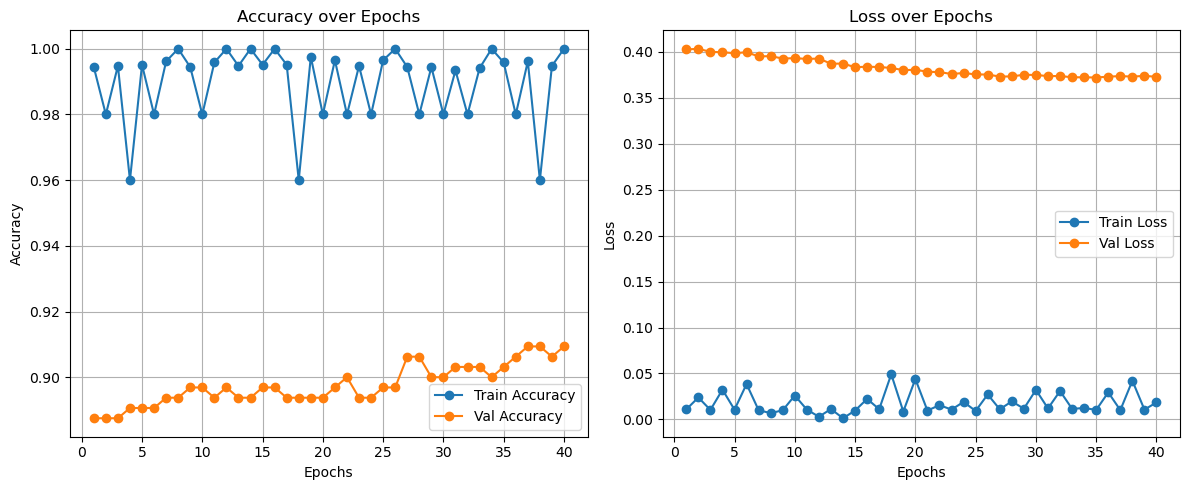


Epoch 40: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0185 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9094 - val_auc: 0.9804 - val_loss: 0.3728 - val_precision_4: 0.9148 - val_recall_4: 0.9062
Epoch 41/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0055 - precision_4: 0.9974 - recall_4: 0.9973Epoch 41: Train Accuracy: 0.9934, Val Accuracy: 0.9094, Train Loss: 0.0103, Val Loss: 0.3752

Epoch 41: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9973 - auc: 1.0000 - loss: 0.0056 - precision_4: 0.9973 - recall_4: 0.9973 - val_accuracy: 0.9094 - val_auc: 0.9803 - val_loss: 0.3752 - val_precision_4: 0.9146 - val_recall_4: 0.9031
Epoch 42/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9600 - auc: 0.9996 - loss: 0.0408 - precision_4: 0.9600 - recall_4: 0.9600Epoch 42: Train Accuracy: 0.9600, Val Accuracy: 0.90

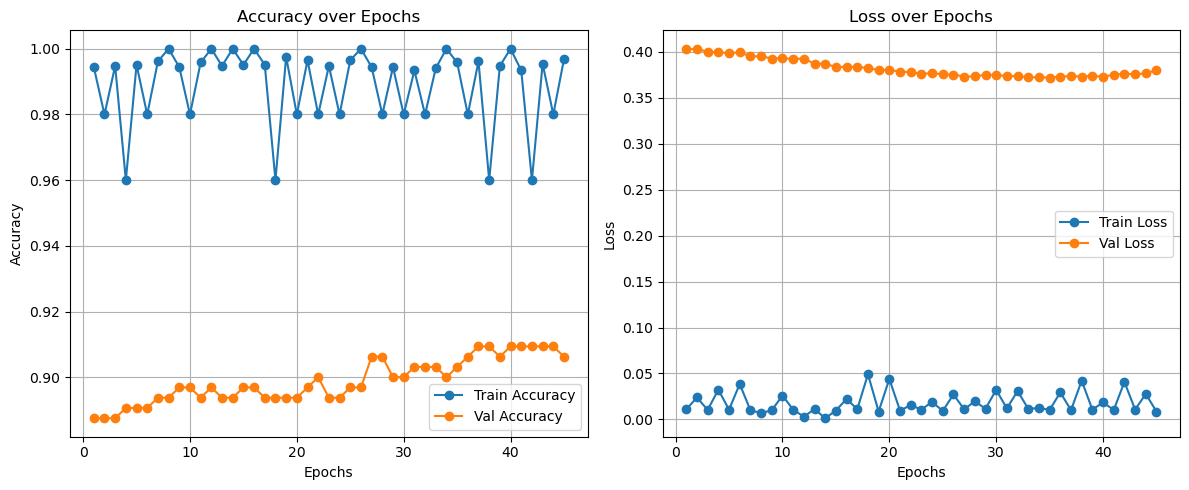


Epoch 45: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9983 - auc: 1.0000 - loss: 0.0047 - precision_4: 0.9985 - recall_4: 0.9983 - val_accuracy: 0.9062 - val_auc: 0.9790 - val_loss: 0.3801 - val_precision_4: 0.9114 - val_recall_4: 0.9000
Epoch 46/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - auc: 0.9999 - loss: 0.0237 - precision_4: 1.0000 - recall_4: 0.9800

2024-12-03 22:53:23.879814: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 46: Train Accuracy: 1.0000, Val Accuracy: 0.9062, Train Loss: 0.0237, Val Loss: 0.3800

Epoch 46: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - auc: 0.9999 - loss: 0.0237 - precision_4: 1.0000 - recall_4: 0.9800 - val_accuracy: 0.9062 - val_auc: 0.9790 - val_loss: 0.3800 - val_precision_4: 0.9114 - val_recall_4: 0.9000
Epoch 47/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0062 - precision_4: 0.9982 - recall_4: 0.9979

2024-12-03 22:53:29.006689: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 47: Train Accuracy: 0.9951, Val Accuracy: 0.9062, Train Loss: 0.0127, Val Loss: 0.3794

Epoch 47: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0063 - precision_4: 0.9981 - recall_4: 0.9978 - val_accuracy: 0.9062 - val_auc: 0.9791 - val_loss: 0.3794 - val_precision_4: 0.9119 - val_recall_4: 0.9062
Epoch 48/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0047 - precision_4: 1.0000 - recall_4: 1.0000

2024-12-03 22:53:29.462817: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 48: Train Accuracy: 1.0000, Val Accuracy: 0.9062, Train Loss: 0.0047, Val Loss: 0.3788

Epoch 48: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0047 - precision_4: 1.0000 - recall_4: 1.0000 - val_accuracy: 0.9062 - val_auc: 0.9791 - val_loss: 0.3788 - val_precision_4: 0.9117 - val_recall_4: 0.9031
Epoch 49/50
 2/45 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0012 - precision_4: 1.0000 - recall_4: 1.0000      

2024-12-03 22:53:30.567667: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536448 bytes after encountering the first element of size 38536448 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0050 - precision_4: 0.9982 - recall_4: 0.9982Epoch 49: Train Accuracy: 0.9958, Val Accuracy: 0.9062, Train Loss: 0.0099, Val Loss: 0.3798

Epoch 49: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0051 - precision_4: 0.9981 - recall_4: 0.9981 - val_accuracy: 0.9062 - val_auc: 0.9792 - val_loss: 0.3798 - val_precision_4: 0.9117 - val_recall_4: 0.9031
Epoch 50/50
 1/45 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9600 - auc: 0.9992 - loss: 0.0548 - precision_4: 0.9600 - recall_4: 0.9600

2024-12-03 22:53:35.224893: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67110144 bytes after encountering the first element of size 67110144 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 50: Train Accuracy: 0.9600, Val Accuracy: 0.9062, Train Loss: 0.0548, Val Loss: 0.3800


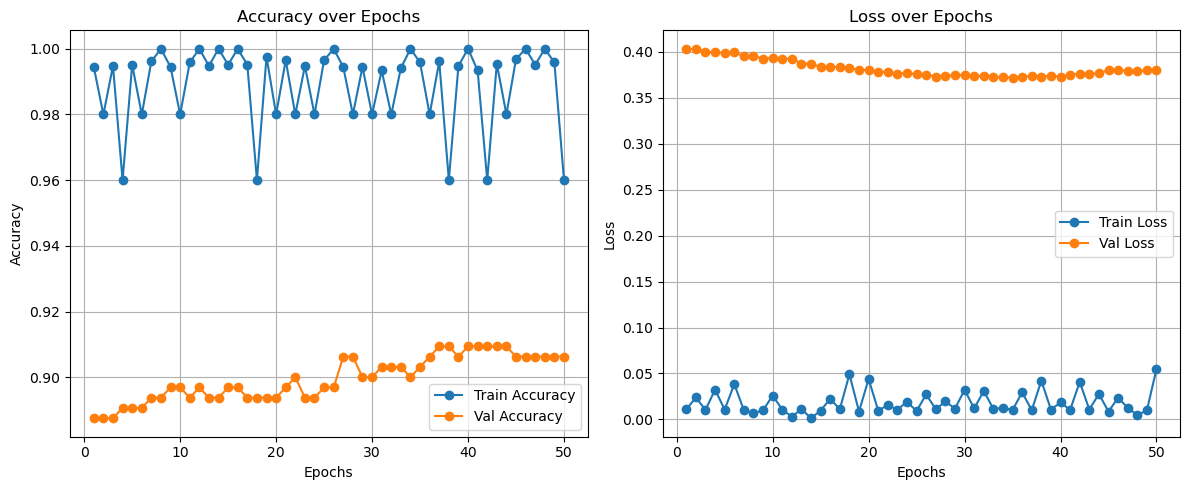


Epoch 50: val_loss did not improve from 0.37207
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9600 - auc: 0.9992 - loss: 0.0548 - precision_4: 0.9600 - recall_4: 0.9600 - val_accuracy: 0.9062 - val_auc: 0.9791 - val_loss: 0.3800 - val_precision_4: 0.9119 - val_recall_4: 0.9062


In [20]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 1e-7  

model.compile(
optimizer=Adam(learning_rate=1e-7), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


## Testing on test data

In [25]:
import tensorflow as tf

# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
test_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_balanced/test.tfrecord')

print(f'test_samples: {test_samples}')

test_samples: 366


In [26]:
# Path to the saved model
saved_model_path = '/media/mydisk/ICDCIT/Diabetic Retinopathy/Diabetic-Retinopathy/best_model.keras'

# Load the saved model
loaded_model = tf.keras.models.load_model(saved_model_path)



results = loaded_model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)
print(f"Loaded model evaluation results: {results}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9282 - auc: 0.9811 - loss: 0.3118 - precision_4: 0.9294 - recall_4: 0.9261
Loaded model evaluation results: [0.5226890444755554, 0.871874988079071, 0.8738170266151428, 0.8656250238418579, 0.9700586795806885]


/home/ritika/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 326 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2024-12-03 23:29:24.718388: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2024-12-03 23:29:32.478570: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1313', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


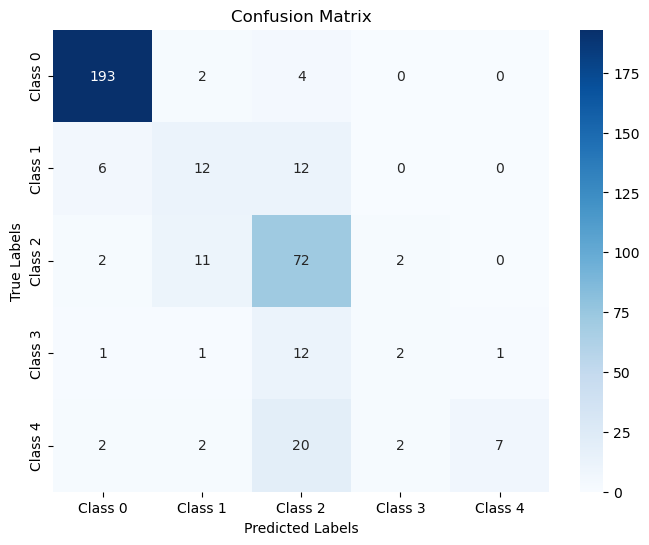

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Step 1: Load TFRecord Dataset

def parse_tfrecord(tfrecord_file, batch_size=32, img_size=(224, 224)):
    # Define the feature structure of the TFRecord (image, label)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    def _parse_function(proto):
        
    # Define TFRecord schema

    # Parse example
        parsed = tf.io.parse_single_example(proto, feature_description)
    # Decode and preprocess image
        image = tf.io.decode_jpeg(parsed['image'], channels=3)
        image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
        label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
        return image, label
    
    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)  # Apply parsing function to each record
    dataset = dataset.batch(batch_size)  # Batch the dataset
    
    return dataset

model = load_model(saved_model_path)

# Step 3: Load the Test Dataset from TFRecord
tfrecord_file = '/media/mydisk/ICDCIT/TFRecords_balanced/test.tfrecord'  # Replace with your TFRecord file path
test_dataset = parse_tfrecord(tfrecord_file)

# Step 4: Make Predictions and Calculate Confusion Matrix
y_true = []
y_pred = []

# Iterate through the dataset and make predictions
for images, labels in test_dataset:
    y_true.append(labels.numpy())  # True labels (one-hot encoded)
    preds = model.predict(images)  # Model predictions (probabilities)
    y_pred.append(np.argmax(preds, axis=1))  # Get class with the highest probability

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Step 5: Compute Confusion Matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Step 6: Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of `model.fit`
def plot_auc(history):
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_auc(history)


NameError: name 'history' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


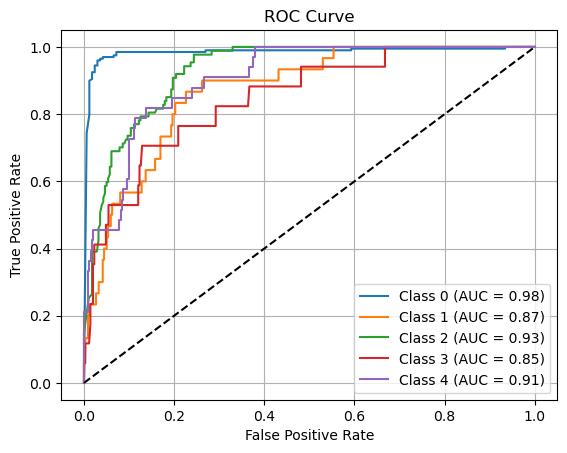

In [17]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming val_dataset contains batched data
y_true = []
y_pred_prob = []

# Extract true labels and predicted probabilities
for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels as integers
    y_pred_prob.extend(loaded_model.predict(images))  # Predicted probabilities

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC for each class
n_classes = y_pred_prob.shape[1]  # Number of classes
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9282 - auc: 0.9811 - loss: 0.3118 - precision_4: 0.9294 - recall_4: 0.9261
Metrics Names: ['loss', 'compile_metrics']
loss: 0.5226890444755554
compile_metrics: 0.871874988079071
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 


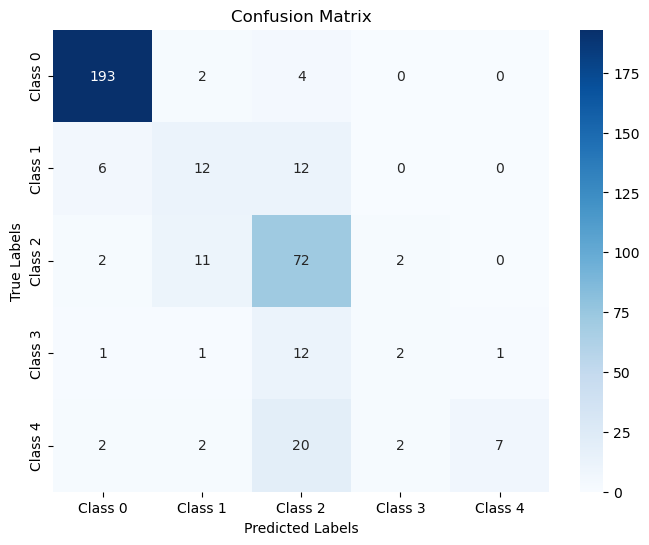

Accuracy: 0.7814207650273224


In [27]:
# Evaluate the model
results = loaded_model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)

# If you want more detailed information about the evaluation:
# Print the metric names
print("Metrics Names:", loaded_model.metrics_names)

# Print the evaluation results for each metric
for name, value in zip(loaded_model.metrics_names, results):
    print(f"{name}: {value}")

# To get more information such as confusion matrix, accuracy, and loss:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.append(labels.numpy())
    preds = loaded_model.predict(images)
    y_pred.append(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Plot confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, calculate accuracy separately
accuracy = np.mean(np.argmax(y_true, axis=1) == y_pred)
print(f"Accuracy: {accuracy}")
